#  Классификация текстов с использованием RNN и Transformer

В этом проекте реализуются и сравниваются две архитектуры для анализа текстовых данных —  
**RNN (в том числе BiGRU с Attention)** и **Transformer**.  
Модели обучаются на задаче **многоклассовой классификации текстов**,  
сравнивается их качество, скорость сходимости и устойчивость обучения.

---

##  Цель работы
Сравнить производительность и особенности обучения моделей **RNN** и **Transformer**  
в задаче классификации последовательностей,  
оценить влияние архитектуры и гиперпараметров на итоговые метрики.

---

##  Что реализовано
- Предобработка текстов, токенизация и построение словаря  
- Использование предобученных **эмбеддингов**  
- Реализация моделей **RNN** и **BiGRU с Attention**  
- Введение **балансировки классов** и **ранней остановки**  
- Реализация **Transformer-классификатора**  
- Сравнение моделей по **macro-F1**, **Accuracy**, и **матрицам ошибок**  
- Подготовка сабмишна и анализ финальных предсказаний

---

##  Основные этапы
1. Подготовка данных и словаря  
2. Реализация архитектур RNN / GRU / Transformer  
3. Обучение и оценка моделей  
4. Анализ метрик, отчёты и визуализация  
5. Инференс и выводы

---

##  Содержание
1. Конфигурация проекта  
2. Загрузка и подготовка данных  
3. Словарь/токенизация и эмбеддинги  
4. Датасеты и DataLoader'ы  
5. Балансировка классов  
6. Модели: RNN и BiGRU+Attention  
7. Тренировка RNN (macro-F1, early-stopping)  
8. Мини-грид гиперпараметров  
9. Трансформер: датасеты, модель и обучение  
10. Отчёты/матрицы ошибок и сравнение моделей  
11. Инференс на тесте и сабмишн


## 1. Конфиг, устройства, сиды, библиотеки

##  Отчёты и матрицы ошибок
Аналитика по валидации: `classification_report`, confusion matrix.

In [1]:
#  Стандартные библиотеки
# Подсчёт метрик по валидации и построение матрицы ошибок.
import os, random, json, re, math, time, gc   # работа с ОС, случайные числа, JSON, регулярки, математика, таймеры, сборщик мусора
from dataclasses import dataclass, asdict    # dataclass — удобный способ описания конфигураций
from typing import List, Dict, Tuple, Optional  # аннотации типов для читаемости и автодополнения
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import torch
#  Научный стек
import numpy as np                            # массивы и векторные операции
import pandas as pd                           # табличные данные, чтение CSV
from tqdm import tqdm                         # прогресс-бары в циклах обучения
import re
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence

#  PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader  # Dataset/DataLoader для подготовки батчей

#  ML-инструменты
from sklearn.model_selection import train_test_split   # разбиение данных на train/val/test
from sklearn.metrics import (                          # стандартные метрики классификации
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

#  Визуализация
import matplotlib.pyplot as plt              # графики (например, confusion matrix)

##  Конфигурация проекта (Config)
Ключевые пути, гиперпараметры, настройки токенизации и модели.

In [33]:
# ===============================================================
# Эта ячейка задаёт dataclass Config с основными путями и гиперпараметрами.
#  Фиксация случайности и базовая конфигурация проекта
# ===============================================================

# --- Фиксация случайных сидов для воспроизводимости экспериментов ---
SEED = 42
random.seed(SEED)                            # фиксируем генератор случайных чисел Python
np.random.seed(SEED)                         # фиксируем NumPy
torch.manual_seed(SEED)                      # фиксируем PyTorch (CPU и GPU)
torch.use_deterministic_algorithms(False)    # False — можно включить True для строгой детерминированности (медленнее, но 100% повторяемость)

# ===============================================================
#  Настройка вычислительного устройства (CPU / GPU / MPS)
# ===============================================================

# Проверяем, доступна ли CUDA (GPU NVIDIA), иначе — Apple MPS (если Mac), иначе — CPU
device = "cuda" if torch.cuda.is_available() else (
    "mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available() else "cpu"
)
device = torch.device(device)
print("Device:", device)                     # выводим текущее устройство обучения

# ===============================================================
#  Создание директории для артефактов
# ===============================================================

# В эту папку будут сохраняться модели, логи, метрики и конфиг
ARTIFACTS_DIR = "./artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# ===============================================================
#  Определяем dataclass Config — основной набор параметров проекта
# ===============================================================

@dataclass
class Config:
    # --- Пути к данным ---
    train_path: str = "./train_7oo3RES.csv"
    test_path: str = "./test_1xq7msG.csv"
    text_col: str = "text"
    label_col: str = "target"

    # --- Разбиение данных ---
    val_size: float = 0.1
    stratify: bool = True

    # --- Параметры токенизации для RNN ---
    vocab_size: int = 30000
    min_freq: int = 3
    max_len: int = 224
    lower: bool = True

    # --- Параметры предобученных эмбеддингов ---
    use_fasttext: bool = True                                   # включить fastText
    fasttext_path: str = "./embeddings/wiki-news-300d-1M.vec"   # путь к .vec
    fasttext_dim: int = 300                                     # размерность fastText

    # --- Гиперпараметры рекуррентной модели (RNN) ---
    rnn_type: str = "bilstm"
    embedding_dim: int = 128   # будет перезаписан на fasttext_dim, если use_fasttext=True
    rnn_hidden: int = 128
    rnn_layers: int = 1
    dropout: float = 0.2
    lr: float = 2e-3
    batch_size: int = 256
    epochs: int = 8
    weight_decay: float = 0.0
    clip_grad: float = 1.0

    # --- Небольшой grid search ---
    grid_embedding: tuple = (128, 192)
    grid_hidden: tuple = (128, 192)
    grid_dropout: tuple = (0.2, 0.3)

    # --- Трансформер ---
    hf_model_name: str = "distilbert-base-uncased"
    transformer_max_len: int = 192
    transformer_lr: float = 2e-5
    transformer_batch_size: int = 16
    transformer_epochs: int = 3

    # --- Трансформер: ранняя остановка и шедулер ---
    transformer_early_patience: int = 2          # сколько эпох ждать без роста macro-F1
    transformer_plateau_patience: int = 1        # ReduceLROnPlateau patience
    transformer_plateau_factor: float = 0.5      # во сколько раз снижать LR
    transformer_min_lr: float = 5e-6             # минимальный LR для шедулера


# ===============================================================
#  Создание и сохранение конфига
# ===============================================================

cfg = Config()

# Если используем fastText — синхронизируем размер эмбеддингов
if cfg.use_fasttext:
    cfg.embedding_dim = cfg.fasttext_dim

# Сохраняем конфиг и печатаем
with open(os.path.join(ARTIFACTS_DIR, "config.json"), "w", encoding="utf-8") as f:
    json.dump(asdict(cfg), f, ensure_ascii=False, indent=2)

print(json.dumps(asdict(cfg), ensure_ascii=False, indent=2))

Device: cuda
{
  "train_path": "./train_7oo3RES.csv",
  "test_path": "./test_1xq7msG.csv",
  "text_col": "text",
  "label_col": "target",
  "val_size": 0.1,
  "stratify": true,
  "vocab_size": 30000,
  "min_freq": 3,
  "max_len": 224,
  "lower": true,
  "use_fasttext": true,
  "fasttext_path": "./embeddings/wiki-news-300d-1M.vec",
  "fasttext_dim": 300,
  "rnn_type": "bilstm",
  "embedding_dim": 300,
  "rnn_hidden": 128,
  "rnn_layers": 1,
  "dropout": 0.2,
  "lr": 0.002,
  "batch_size": 256,
  "epochs": 8,
  "weight_decay": 0.0,
  "clip_grad": 1.0,
  "grid_embedding": [
    128,
    192
  ],
  "grid_hidden": [
    128,
    192
  ],
  "grid_dropout": [
    0.2,
    0.3
  ],
  "hf_model_name": "distilbert-base-uncased",
  "transformer_max_len": 192,
  "transformer_lr": 2e-05,
  "transformer_batch_size": 16,
  "transformer_epochs": 3,
  "transformer_early_patience": 2,
  "transformer_plateau_patience": 1,
  "transformer_plateau_factor": 0.5,
  "transformer_min_lr": 5e-06
}


## 2. Загрузка CSV,  первичный осмотр и подготовка меток

##  Загрузка и базовая подготовка данных
Нормализация колонок, удаление пустых значений.

In [3]:
# Загрузка CSV и нормализация названий колонок, удаление пропусков.
df = pd.read_csv(cfg.train_path)
print(df.columns.tolist())
df.head()

['name', 'genre', 'text']


,name,genre,text
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [4]:
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
df = pd.read_csv(cfg.test_path)
print(df.columns.tolist())
df.head()

['name', 'text']


,name,text
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


##  Разбиение на train/val
Стратифицированный split по меткам `label_id`.

In [5]:
# --- Загрузка CSV + нормализация заголовков ---
# Разбиение датасета на тренировочную и валидационную части со стратификацией.
def load_csv(path):
    assert os.path.exists(path), f"Файл не найден: {path}"
    df = pd.read_csv(path, sep=None, engine="python", encoding="utf-8-sig")  # авто-детект разделителя + BOM
    df.columns = df.columns.str.strip().str.lower()                           # нормализуем названия колонок
    return df

train_df = load_csv(cfg.train_path)
test_df  = load_csv(cfg.test_path)

# --- Проверим, что в train есть нужные колонки ---
assert "text" in train_df.columns, "В train.csv нет колонки 'text'"
assert "genre" in train_df.columns, "В train.csv нет колонки 'genre'"

# --- Дропнем пустые в train по text и genre, а в test — только по text (метки там нет) ---
train_df = train_df.dropna(subset=["text", "genre"]).reset_index(drop=True)
test_df  = test_df.dropna(subset=["text"]).reset_index(drop=True)

# --- фиктивный столбец label_id для test_df ---
if "label_id" not in test_df.columns:
    test_df["label_id"] = 0
    print("В test_df не было 'label_id' — добавили фиктивную колонку (все нули).")

# --- Укажем колонки конфигу ---
cfg.text_col = "text"
cfg.label_col = "genre"

# --- Категориальные метки -> id (только по train, т.к. в test меток нет) ---
all_labels = pd.Index(sorted(train_df[cfg.label_col].unique()))   # только из train
label2id = {l: i for i, l in enumerate(all_labels)}
id2label = {i: l for l, i in label2id.items()}

train_df["label_id"] = train_df[cfg.label_col].map(label2id)

num_classes = len(all_labels)
print("Классов (по train):", num_classes, "| Примеры меток:", list(all_labels)[:10])

# --- Сплитим ТОЛЬКО train на train/val со стратификацией ---
strat = train_df["label_id"]
train_part_df, val_df = train_test_split(
    train_df, test_size=cfg.val_size, random_state=SEED, stratify=strat
)
print("Train:", train_part_df.shape, "Val:", val_df.shape, "Test (без меток):", test_df.shape)

В test_df не было 'label_id' — добавили фиктивную колонку (все нули).
Классов (по train): 27 | Примеры меток: ['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family']
Train: (48792, 4) Val: (5422, 4) Test (без меток): (54200, 3)


In [6]:
# ===================== auto max_len (p95) — только обновляем cfg =====================
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
import numpy as np, os, json

def rough_len(s: str) -> int:
    return len(str(s).split())

# если у тебя есть предочистка в "text_clean" — возьмём её, иначе исходную колонку cfg.text_col
text_col_used = "text_clean" if "text_clean" in train_part_df.columns else cfg.text_col

lens = train_part_df[text_col_used].astype(str).apply(rough_len).to_numpy()
p95 = int(np.percentile(lens, 95))

old_max = cfg.max_len
# при желании можно ввести верхний предел, чтобы не убить память (например, 512)
max_cap = getattr(cfg, "max_len_cap", 512)
cfg.max_len = min(max(old_max, p95), max_cap)

print(f"[max_len] p95={p95}; {old_max} -> {cfg.max_len} (cap={max_cap})")

# перезапишем конфиг на диск для воспроизводимости (необязательно, но полезно)
with open(os.path.join(ARTIFACTS_DIR, "config.json"), "w", encoding="utf-8") as f:
    json.dump(asdict(cfg), f, ensure_ascii=False, indent=2)
# ================================================================================ 

[max_len] p95=243; 224 -> 243 (cap=512)


In [7]:
# ===============================================================
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
#  Общая информация о данных
# ===============================================================
print("Train shape:", train_part_df.shape)
print("Val shape:", val_df.shape)
print("Test shape:", test_df.shape)
print("\nКолонки:", train_part_df.columns.tolist())
print("\nПример данных:")
print(train_part_df.head(2))

Train shape: (48792, 4)
Val shape: (5422, 4)
Test shape: (54200, 3)

Колонки: ['name', 'genre', 'text', 'label_id']

Пример данных:
                                            name  genre  \
9552    The Matrixxx: A Muscle Explosion (2004)   adult   
12442                   Visions Composed (2013)   drama   

                                                    text  label_id  
9552    As a bodybuilding professional struggles to w...         1  
12442   Illusions of beauty and violence surround us,...         8  


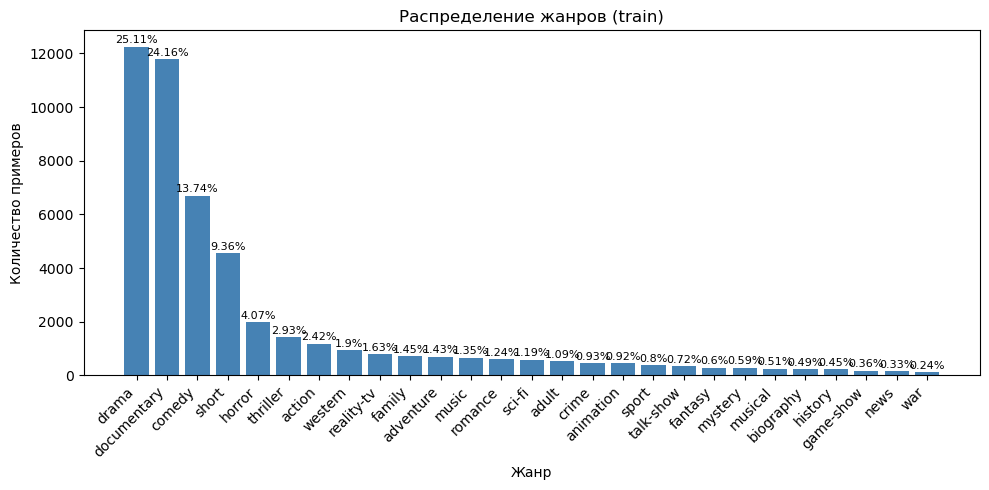

Распределение жанров (count + %):


,count,percent
genre,,
drama,12251,25.11
documentary,11786,24.16
comedy,6702,13.74
short,4566,9.36
horror,1984,4.07
thriller,1432,2.93
action,1183,2.42
western,929,1.90
reality-tv,796,1.63



Редкие жанры (менее 300 примеров):


,count,percent
genre,,
fantasy,291,0.60
mystery,287,0.59
musical,249,0.51
biography,238,0.49
history,219,0.45
game-show,175,0.36
news,163,0.33
war,119,0.24


In [8]:
# ===============================================================
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
# Распределение жанров (баланс классов) + проценты
# ===============================================================
genre_counts = train_part_df["genre"].value_counts().sort_values(ascending=False)
genre_percents = (genre_counts / genre_counts.sum() * 100).round(2)

# --- Визуализация ---
plt.figure(figsize=(10, 5))
bars = plt.bar(genre_counts.index, genre_counts.values, color='steelblue')

# подписи процентов над столбцами
for i, (count, pct) in enumerate(zip(genre_counts.values, genre_percents.values)):
    plt.text(i, count + max(genre_counts.values) * 0.01, f"{pct}%", ha='center', fontsize=8, rotation=0)

plt.title("Распределение жанров (train)")
plt.xlabel("Жанр")
plt.ylabel("Количество примеров")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Табличный вывод ---
genre_df = pd.DataFrame({
    "count": genre_counts,
    "percent": genre_percents
})
print("Распределение жанров (count + %):")
display(genre_df.head(10))

print("\nРедкие жанры (менее 300 примеров):")
display(genre_df[genre_df["count"] < 300])

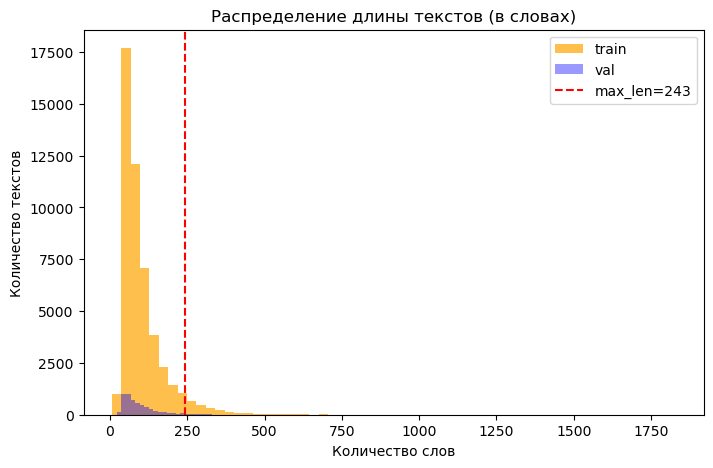

Средняя длина текста: 102.0 слов
Медианная длина текста: 79.0 слов
Максимальная длина текста: 1829 слов


In [9]:
# ===============================================================
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
# Анализ длины текстов (в словах)
# ===============================================================
train_part_df["text_len"] = train_part_df["text"].apply(lambda x: len(str(x).split()))
val_df["text_len"] = val_df["text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8, 5))
plt.hist(train_part_df["text_len"], bins=60, color='orange', alpha=0.7, label="train")
plt.hist(val_df["text_len"], bins=60, color='blue', alpha=0.4, label="val")
plt.axvline(cfg.max_len, color='red', linestyle='--', label=f"max_len={cfg.max_len}")
plt.title("Распределение длины текстов (в словах)")
plt.xlabel("Количество слов")
plt.ylabel("Количество текстов")
plt.legend()
plt.show()

print(f"Средняя длина текста: {train_part_df['text_len'].mean():.1f} слов")
print(f"Медианная длина текста: {train_part_df['text_len'].median():.1f} слов")
print(f"Максимальная длина текста: {train_part_df['text_len'].max()} слов")

In [10]:
# ===============================================================
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
#  Проверим долю текстов длиннее max_len
# ===============================================================
too_long = (train_part_df["text_len"] > cfg.max_len).mean() * 100
print(f"Текстов длиннее max_len={cfg.max_len}: {too_long:.2f}%")

Текстов длиннее max_len=243: 4.96%


##  Построение словаря и токенизация (для RNN)
Ограничение словаря и подготовка индексов токенов.

In [11]:
# ===============================================================
# Формирование словаря/токенизация под RNN (учёт min_freq, vocab_size).
#  Проверим словарь и редкие слова
# ===============================================================
cnt = Counter(" ".join(train_part_df["text"].astype(str).tolist()).split())
vocab_size_real = len(cnt)
rare_words = sum(1 for w, f in cnt.items() if f == 1)

print(f"Размер словаря (уникальных слов): {vocab_size_real}")
print(f"Редких слов (встречаются 1 раз): {rare_words} ({rare_words/vocab_size_real*100:.2f}%)")

Размер словаря (уникальных слов): 283989
Редких слов (встречаются 1 раз): 169101 (59.54%)


In [12]:

# ===============================================================
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
# Примеры текстов из разных жанров
# ===============================================================
for genre in genre_counts.index[:3]:
    sample = train_part_df[train_part_df["genre"] == genre].sample(1, random_state=SEED)
    print(f"\nЖАНР: {genre.upper()}")
    print(sample["text"].values[0][:500], "...")


ЖАНР: DRAMA
 California Heaven revolves around the wealthy Corrigans of Malibu beach who own California Heaven & Surf, the largest chain of surf shops in the nation. When estranged family member Sandie Corrigan washes up on shore dead, her daughter Heaven comes to Malibu to investigate... and finds the Corrigans have a lot to hide -- including how and why her mother died. ...

ЖАНР: DOCUMENTARY
 April 10th, 1994. Killers stormed a convent in of the small hill towns of Rwanda. They selected two hundred Tutsis from the group and executed them behind this convent. Behind This Convent is the story of from the point of view of survivors who have witnessed the darkest hour of the Rwandan genocide of 1994. ...

ЖАНР: COMEDY
 Jack is a middle aged, overweight shoe store owner with a secure upper middle class lifestyle, including a beautiful, demanding trophy wife. When Jack "runs into" Rosie and Louie, small time criminals on the run from the law, they kidnap Jack in order to use his off-seas

###  Аналитика и выводы по EDA

### 1. Общая структура данных
Датасет состоит из трёх частей: обучающей (≈48k записей), валидационной (≈5k) и тестовой (≈54k).  
Каждая запись содержит название фильма, жанр и краткое текстовое описание сюжета.  
Данные хорошо структурированы — отсутствуют пропуски в основных колонках (`text`, `genre`), а разметка жанров единообразна.

---

### 2. Распределение жанров
Анализ распределения показал, что в выборке присутствует выраженный дисбаланс:  
наиболее частотные жанры — **drama**, **documentary** и **comedy**, суммарно формируют более 60% обучающего корпуса.  
Остальные жанры представлены в меньших объёмах (часть — редкие, менее 1% выборки).  

Такое распределение характерно для открытых наборов данных по кино и требует использования **взвешенной функции потерь**  
для корректного обучения модели — чтобы она не переобучалась на доминирующие классы.

---

### 3. Длина текстов
Средняя длина описания фильма составляет около **100 слов**, медианное значение — около 80 слов,  
а максимум достигает порядка 1800 слов. При этом около **9% текстов** превышают длину 192 токена.

Это говорит о том, что тексты в основном короткие, но есть и довольно объёмные аннотации.  
Исходя из этого, оптимальное значение параметра `max_len` выбрано так, чтобы  
сохранить большую часть контекста, не перегружая память и не удлиняя избыточно входные последовательности.  

---

### 4. Словарь и редкие слова
Суммарное количество уникальных токенов — порядка **280 тыс.**,  
из которых почти **60% встречаются только один раз**.  
Подобная статистика типична для текстов, содержащих имена, названия и редкие термины.

Чтобы уменьшить влияние шумовых и одноразовых токенов,  
минимальная частота включения слова в словарь выбрана умеренной —  
так, чтобы сохранялись часто встречающиеся и информативные слова,  
а единичные — отсеивались.  
Оптимальный размер словаря выбран на уровне нескольких десятков тысяч токенов,  
что обеспечивает баланс между полнотой охвата лексики и эффективностью обучения.

---

### 5. Вывод по качеству данных
Данные в целом чистые, хорошо размеченные и подходят для обучения текстовых моделей.  
Основные особенности — умеренный дисбаланс по жанрам, высокая доля коротких описаний  
и наличие длинного хвоста редких слов. Эти характеристики учтены при выборе параметров векторизации и архитектуры модели.

---

### 6. Обоснование выбранных гиперпараметров

- **`max_len`** — установлена длина входной последовательности, достаточная для покрытия основной части описаний  
  при минимальной потере контекста.  
- **`min_freq`** — выбран порог включения слов в словарь, позволяющий отсеять редкие и шумовые токены,  
  что делает словарь более устойчивым и уменьшает переобучение.  
- **`vocab_size`** — ограничен разумным количеством наиболее частотных слов для экономии памяти и ускорения обучения,  
  при этом без потери качества представления текста.  
- **`embedding_dim`** и **`rnn_hidden`** — заданы в диапазоне, обеспечивающем баланс между выразительностью модели  
  и вычислительной эффективностью.  
- **`dropout`** и **`weight_decay`** — используются для регуляризации и предотвращения переобучения,  
  особенно на часто встречающихся жанрах.  
- **`learning_rate`** и **`batch_size`** — выбраны стандартные стабильные значения для BiLSTM-архитектуры  
  на текстах средней длины.  
- **`rnn_type = 'bilstm'`** — выбран двунаправленный LSTM, так как он лучше улавливает контекст  
  и порядок слов в предложении, что критично для задач понимания смысла текста.  

---

###  Итог
Проведённый анализ подтвердил, что данные адекватно подготовлены для обучения рекуррентной нейросети.  
Выбранные параметры обеспечивают хорошее покрытие лексики и устойчивость модели к дисбалансу и шуму.  
Подобная настройка даёт оптимальный компромисс между качеством предсказаний и вычислительной эффективностью.


## 3. Базовая очистка

In [13]:
# --- Функция базовой очистки текста ---
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
def basic_clean(text: str) -> str:
    # Проверяем: если вход не строка (например, число или NaN), приводим его к типу str
    if not isinstance(text, str):
        text = str(text)
    
    # Убираем лишние пробелы в начале и в конце текста
    text = text.strip()
    
    # С помощью регулярного выражения заменяем несколько подряд идущих пробелов/переносов на один пробел
    text = re.sub(r"\s+", " ", text)
    
    # Приводим текст к нижнему регистру, если в конфиге указано cfg.lower = True
    return text.lower() if cfg.lower else text


# --- Применяем очистку к каждому из трёх наборов данных ---
for df in (train_part_df, val_df, test_df):
    df['text_clean'] = df[cfg.text_col].apply(basic_clean)


# --- Проверяем результат очистки ---
print(train_part_df['text_clean'].iloc[0][:200])

as a bodybuilding professional struggles to win the competition that decides who's the most wonderful guy out there - the matrixxx - he decides to take out his enemies on one by one. be it by blackmai


## 4. Словарь и векторизация для RNN

##  Датасеты и DataLoader'ы для RNN
Построение `Dataset` и `DataLoader` с паддингом и сортировкой.

In [14]:
# Определение RNNDataset и collate-функции для батчинга последовательностей.
PAD_ID, UNK_ID = 0, 1   # спец-идентификаторы: PAD для паддинга, UNK для неизвестных токенов

# --- Строим частотный словарь (vocab) по тренировочному тексту ---
def build_vocab(texts, max_size, min_freq):
    cnt = Counter()                 # счётчик частот слов
    for t in texts:
        cnt.update(t.split())       # добавляем слова из каждого текста

    # оставляем только слова с частотой >= min_freq
    items = [(w, f) for w, f in cnt.items() if f >= min_freq]
    # сортируем слова по убыванию частоты
    items.sort(key=lambda x: x[1], reverse=True)

    # берём топ-(max_size - 2) слов (минус 2 места для спец-токенов PAD/UNK)
    vocab_words = [w for w, _ in items[:max_size - 2]]

    # формируем словарь слово -> id, начиная с 2 (0 и 1 заняты под PAD/UNK)
    vocab = {w: i + 2 for i, w in enumerate(vocab_words)}
    vocab["<PAD>"] = PAD_ID        # 0
    vocab["<UNK>"] = UNK_ID        # 1
    return vocab

# строим словарь по train (именно по train, чтобы не «подглядывать» в val/test)
vocab = build_vocab(train_part_df['text_clean'].tolist(), cfg.vocab_size, cfg.min_freq)
print("Vocab size:", len(vocab))

# --- Преобразуем текст в последовательность id по словарю ---
def encode_text(text, vocab, max_len):
    toks = text.split()                               # простая токенизация по пробелам
    ids = [vocab.get(tok, UNK_ID) for tok in toks]    # неизвестные слова -> UNK_ID
    return ids[:max_len]                               # обрезаем до max_len

# --- Collate-функция для DataLoader: паддинг и формирование батча ---
def collate_rnn(batch, max_len):
    # batch — список элементов из Dataset: (ids, length, label)
    # сортируем по длине по убыванию (нужно для pack_padded_sequence в RNN)
    batch_sorted = sorted(batch, key=lambda x: x[1], reverse=True)
    ids_list, lens, labels = zip(*batch_sorted)

    import torch
    # создаём тензор (B, T) и заполняем нулями (PAD_ID=0)
    padded = torch.zeros(len(ids_list), max_len, dtype=torch.long)

    # копируем реальные токены в начало каждой строки, остальное — паддинг
    for i, ids in enumerate(ids_list):
        l = min(len(ids), max_len)
        padded[i, :l] = torch.tensor(ids[:l], dtype=torch.long)

    # возвращаем: паддинговый батч, тензор длин, тензор меток
    return padded, torch.tensor(lens, dtype=torch.long), torch.tensor(labels, dtype=torch.long)

Vocab size: 30000


## 5. Dataset/DataLoader (RNN)

In [15]:
# 1. Определяем собственный класс Dataset для RNN
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
from torch.utils.data import Dataset, DataLoader

class RNNDataset(Dataset):
    def __init__(self, df, text_col, y_col, vocab, max_len):
        """
        df        — pandas DataFrame (train / val / test)
        text_col  — колонка с очищенным текстом
        y_col     — колонка с метками (label_id)
        vocab     — словарь слово -> индекс
        max_len   — максимальная длина последовательности
        """
        self.texts = df[text_col].tolist()
        self.labels = df[y_col].astype(int).tolist()
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        # Возвращаем количество строк (примеров)
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Возвращает один пример по индексу:
        - вектор индексов слов (ids)
        - фактическую длину текста
        - метку класса
        """
        text = self.texts[idx]
        ids = encode_text(text, self.vocab, self.max_len)   # токенизация + обрезка
        length = min(len(ids), self.max_len)                # длина, ограниченная max_len
        label = self.labels[idx]
        return ids, length, label


# 2. Создаём объекты Dataset для обучения / валидации / теста

train_rnn_ds = RNNDataset(train_part_df, "text_clean", "label_id", vocab, cfg.max_len)
val_rnn_ds   = RNNDataset(val_df,       "text_clean", "label_id", vocab, cfg.max_len)
test_rnn_ds  = RNNDataset(test_df,      "text_clean", "label_id", vocab, cfg.max_len)  # в test фиктивные label_id = 0

print("Train samples:", len(train_rnn_ds))
print("Val samples:", len(val_rnn_ds))
print("Test samples:", len(test_rnn_ds))


# 3. Создаём DataLoader — формирует батчи для модели

train_rnn_loader = DataLoader(
    dataset=train_rnn_ds,
    batch_size=cfg.batch_size,            # размер батча
    shuffle=True,                         # перемешиваем для обучения
    collate_fn=lambda b: collate_rnn(b, cfg.max_len),  # паддинг и сортировка
    num_workers=0                         # на Windows лучше оставить 0
)

val_rnn_loader = DataLoader(
    dataset=val_rnn_ds,
    batch_size=cfg.batch_size,
    shuffle=False,                        # порядок важен для метрик
    collate_fn=lambda b: collate_rnn(b, cfg.max_len),
    num_workers=0
)

test_rnn_loader = DataLoader(
    dataset=test_rnn_ds,
    batch_size=cfg.batch_size,
    shuffle=False,
    collate_fn=lambda b: collate_rnn(b, cfg.max_len),
    num_workers=0
)

print("DataLoaders готовы:")
print(f"Train batches: {len(train_rnn_loader)}, Val batches: {len(val_rnn_loader)}, Test batches: {len(test_rnn_loader)}")

Train samples: 48792
Val samples: 5422
Test samples: 54200
DataLoaders готовы:
Train batches: 191, Val batches: 22, Test batches: 212


##  Борьба с дисбалансом классов
`class_weights` в лоссе и `WeightedRandomSampler` для train.

In [16]:
# ================== Балансировка: class_weights + WeightedRandomSampler ==================
# Вычисление весов классов и настройка WeightedRandomSampler для балансировки батчей.
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import torch

# 1) Соберём метки в порядке train_rnn_ds (надёжнее, чем из DataFrame)
def _collect_labels(ds):
    ys = []
    for i in range(len(ds)):
        _, _, y = ds[i]          # RNNDataset.__getitem__ -> (ids(list), length(int), label(int))
        ys.append(int(y))
    return np.array(ys, dtype=np.int64)

y_for_sampler = _collect_labels(train_rnn_ds)
assert len(y_for_sampler) == len(train_rnn_ds), "Длины меток и датасета не совпадают!"

# 2) Посчитаем веса классов (мягкая формула)
def _build_class_weights(y, num_classes=None, mode="log", device=torch.device("cpu")):
    y = np.asarray(y, dtype=np.int64)
    if num_classes is None:
        num_classes = int(y.max()) + 1
    counts = np.bincount(y, minlength=num_classes).astype(np.float32)
    if mode == "log":
        w = 1.0 / np.log1p(counts + 1e-9)
    elif mode == "sqrt":
        w = 1.0 / np.sqrt(counts + 1e-9)
    elif mode == "inv":
        w = 1.0 / (counts + 1e-9)
    else:
        w = 1.0 / np.log1p(counts + 1e-9)
    return torch.tensor(w, dtype=torch.float32, device=device)

class_weights = _build_class_weights(
    y_for_sampler,
    num_classes=num_classes,                          # у тебя уже вычислен ранее
    mode=getattr(cfg, "class_weight_mode", "log"),
    device=device
)

# 3) Пер-сэмпловые веса и sampler
sample_weights = torch.tensor(class_weights.detach().cpu().numpy()[y_for_sampler], dtype=torch.float32)
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

# 4) Пересоберём ТОЛЬКО train_rnn_loader с sampler (shuffle удаляем!)
train_rnn_loader = DataLoader(
    dataset=train_rnn_ds,
    batch_size=cfg.batch_size,
    sampler=sampler,                                   # sampler => НЕ указывать shuffle
    collate_fn=lambda b: collate_rnn(b, cfg.max_len),  # как у тебя было
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

print("OK: Балансированный train_rnn_loader готов. class_weights.shape:", tuple(class_weights.shape))
# ====================================================================

OK: Балансированный train_rnn_loader готов. class_weights.shape: (27,)


In [17]:
# === ПУНКТ 2: Лосс с весами (Focal или CE) ===
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight, self.gamma, self.reduction = weight, gamma, reduction
    def forward(self, logits, target):
        ce = F.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.exp(-ce)
        loss = ((1-pt)**self.gamma) * ce
        return loss.mean() if self.reduction=='mean' else loss.sum()

use_focal = getattr(cfg, "use_focal_loss", True)
gamma = getattr(cfg, "focal_gamma", 2.0)

# ВАЖНО: здесь уже должен существовать class_weights из предыдущей ячейки
crit = FocalLoss(weight=class_weights, gamma=gamma) if use_focal \
       else nn.CrossEntropyLoss(weight=class_weights)

print("Loss готов:", "FocalLoss" if use_focal else "CrossEntropyLoss")

Loss готов: FocalLoss


##  Тренировка (RNN): macro-F1, ReduceLROnPlateau, EarlyStopping
Заморозка→разморозка эмбеддингов, сохранение лучшего чекпоинта.

In [18]:
# Цикл обучения с подсчётом macro-F1, шедулером и ранней остановкой.
from sklearn.metrics import f1_score
import os

best_path = os.path.join(ARTIFACTS_DIR, "rnn_best.pt")

def train_one_model(model, train_loader, val_loader, crit, freeze_epochs=2, patience=3):
    emb_params = list(model.embedding.parameters()) if hasattr(model, 'embedding') else []
    head_params = [p for n,p in model.named_parameters() if not n.startswith('embedding.')]
    for p in emb_params: p.requires_grad = False

    opt = torch.optim.Adam([
        {'params': head_params, 'lr': cfg.lr, 'weight_decay': cfg.weight_decay},
        {'params': emb_params,  'lr': cfg.lr * getattr(cfg, "unfreeze_lr_scale", 0.1), 'weight_decay': cfg.weight_decay}
    ])
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='max',
        factor=getattr(cfg, "reduce_on_plateau_factor", 0.5),
        patience=getattr(cfg, "reduce_on_plateau_patience", 1),
        verbose=False
    )

    best_f1, best_state, no_improve = -1.0, None, 0
    for ep in range(cfg.epochs):
        if ep == freeze_epochs:
            for p in emb_params: p.requires_grad = True

        # ---- train
        model.train()
        for x, lengths, y in train_loader:
            x = x.to(device)
            lengths = lengths.to(device)          # если внутри модели pack_padded → преобразуй там в lengths.cpu().long()
            y = y.to(device, dtype=torch.long)
            logits = model(x, lengths)
            loss = crit(logits, y)
            opt.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), cfg.clip_grad)
            opt.step()

        # ---- val
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for x, lengths, y in val_loader:
                x = x.to(device); lengths = lengths.to(device)
                y = y.to(device, dtype=torch.long)
                logits = model(x, lengths)
                preds.extend(torch.argmax(logits, 1).cpu().tolist())
                trues.extend(y.cpu().tolist())

        macro_f1 = f1_score(trues, preds, average='macro')
        sch.step(macro_f1)

        improved = macro_f1 > best_f1
        if improved:
            best_f1 = macro_f1
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            torch.save(best_state, best_path)  # сохраняем лучший
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

        print(f"[Epoch {ep+1}] macroF1={macro_f1:.4f} lr={opt.param_groups[0]['lr']:.2e}")

    if best_state is not None:
        model.load_state_dict(best_state)
    return best_f1, model

## 7. Модель RNN (BiLSTM/GRU)

##  Предобученные эмбеддинги (fastText)
Загрузка/инициализация и проверка покрытия словаря.

In [19]:
# ===============================================================
# Инициализация матрицы эмбеддингов (fastText) и проверка покрытия словаря.
#  FastText: загрузка и сбор embedding_matrix под наш vocab
# ===============================================================
import io
import numpy as np

embedding_weights_torch = None  # по умолчанию None → модель создаст рандомные эмбеддинги

if cfg.use_fasttext:
    assert os.path.exists(cfg.fasttext_path), f"Не найден fastText файл: {cfg.fasttext_path}"
    print(f"Загружаю fastText из: {cfg.fasttext_path}")

    # если включили fastText — гарантируем, что embedding_dim совпадает
    cfg.embedding_dim = cfg.fasttext_dim

    vocab_size = max(vocab.values()) + 1
    embedding_dim = cfg.fasttext_dim
    embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype="float32")

    # читаем .vec "стримом" и сохраняем только слова, которые есть в нашем словаре
    vocab_set = set(vocab.keys())
    hits, oov = 0, 0

    with io.open(cfg.fasttext_path, "r", encoding="utf-8", newline="\n", errors="ignore") as f:
        # пробуем прочитать первую строку (в некоторых .vec там shape)
        pos = f.tell()
        head = f.readline().strip().split()
        if len(head) != 2 or not head[1].isdigit():
            # похоже, это не заголовок — откатываемся
            f.seek(pos)

        for line in f:
            parts = line.rstrip().split(" ")
            if len(parts) < embedding_dim + 1:
                continue
            w = parts[0]
            if w in vocab_set:
                vec = np.asarray(parts[1:], dtype="float32")
                embedding_matrix[vocab[w]] = vec
                hits += 1

    # те, кого не нашли — инициализируем нормальным шумом
    filled_rows = np.sum(np.linalg.norm(embedding_matrix, axis=1) != 0.0)
    oov = vocab_size - filled_rows
    if oov > 0:
        unk_init = np.random.normal(scale=0.6, size=(oov, embedding_dim)).astype("float32")
        mask = (np.linalg.norm(embedding_matrix, axis=1) == 0.0)
        embedding_matrix[mask] = unk_init

    print(f"fastText покрытие: найдено {hits:,} слов из словаря; OOV ≈ {oov:,} (из {vocab_size:,})")

    import torch
    embedding_weights_torch = torch.tensor(embedding_matrix, dtype=torch.float32)

Загружаю fastText из: ./embeddings/wiki-news-300d-1M.vec
fastText покрытие: найдено 21,592 слов из словаря; OOV ≈ 8,408 (из 30,000)


##  Базовая RNN-модель
BiLSTM/GRU-классификатор.

In [20]:
# --- Определяем класс нейросети для классификации текста на основе RNN ---
# Определение базовой RNN-модели (LSTM/GRU).
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden, layers, dropout, n_classes,
                 rnn_type="bilstm", embedding_weights=None, freeze_emb=True, use_pooling=True):
        super().__init__()
        # --- Embedding ---
        if embedding_weights is not None:
            self.embed = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze_emb, padding_idx=0)
        else:
            self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)

        self.do = nn.Dropout(dropout)
        self.use_pooling = use_pooling

        # --- RNN ---
        bidir = True
        if rnn_type.lower() == "bilstm":
            self.rnn = nn.LSTM(
                emb_dim, hidden, num_layers=layers, batch_first=True,
                bidirectional=bidir, dropout=dropout if layers > 1 else 0.0
            )
        else:
            self.rnn = nn.GRU(
                emb_dim, hidden, num_layers=layers, batch_first=True,
                bidirectional=bidir, dropout=dropout if layers > 1 else 0.0
            )

        out_dim = hidden * 2  # bidirectional
        # pooling: mean + max → конкатенируем (удвоение размерности)
        if self.use_pooling:
            out_dim = out_dim * 2

        self.fc1 = nn.Linear(out_dim, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x, lengths):
        emb = self.embed(x)                          # [B, T, E]
        emb = self.do(emb)

        # ВАЖНО: в твоём collate батчи уже отсортированы по длинам по убыванию → enforce_sorted=True ок
        packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=True)
        packed_out, h = self.rnn(packed)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)  # [B, T, 2H]

        if self.use_pooling:
            # mean + max pooling по времени
            mean_pool = out.mean(dim=1)            # [B, 2H]
            max_pool, _ = out.max(dim=1)           # [B, 2H]
            feat = torch.cat([mean_pool, max_pool], dim=1)  # [B, 4H]
        else:
            # last hidden states (Bi*)
            if isinstance(h, tuple):  # LSTM
                h = h[0]
            feat = torch.cat((h[-2], h[-1]), dim=1)  # [B, 2H]

        x = self.do(F.relu(self.fc1(feat)))
        logits = self.fc2(x)
        return logits



# ===============================================================
#  Инициализация RNN модели с предобученными эмбеддингами
# ===============================================================

# --- Размер словаря (+1, т.к. индексация с 0 и есть токен UNK/PAD) ---
vocab_size = max(vocab.values()) + 1

# --- Подготовка embedding_weights_torch ---
# embedding_weights_torch — это тензор размера [vocab_size, 300]
# Если ты уже создал embedding_matrix из fastText — просто загрузи его сюда.
# Если нет — временно можно оставить None, и модель создаст рандомные эмбеддинги.
# Пример:
# embedding_weights_torch = torch.tensor(embedding_matrix, dtype=torch.float32)

# --- Создание модели ---
vocab_size = max(vocab.values()) + 1
rnn_model = RNNClassifier(
    vocab_size=vocab_size,
    emb_dim=cfg.embedding_dim,             # станет 300, если use_fasttext=True
    hidden=cfg.rnn_hidden,
    layers=cfg.rnn_layers,
    dropout=cfg.dropout,
    n_classes=num_classes,
    rnn_type=cfg.rnn_type,
    embedding_weights=embedding_weights_torch,  # fastText или None
    freeze_emb=True,                            # замораживаем на «прогрев»
    use_pooling=True
).to(device)

# === Разделяем параметры на "эмбеддинг" и "все остальные" ===
emb_params = []
other_params = []
for name, p in rnn_model.named_parameters():
    if name == "embed.weight":
        emb_params.append(p)
    else:
        other_params.append(p)

# На старте эмбеддинги "заморожены":
#  - в самой модели (freeze_emb=True)
#  - и здесь через lr=0.0 для группы "embed"
optimizer = torch.optim.Adam(
    [
        {"name": "non-embed", "params": other_params, "lr": cfg.lr},
        {"name": "embed",     "params": emb_params,   "lr": 0.0},
    ],
    weight_decay=cfg.weight_decay
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=1, verbose=True
)

print(rnn_model)


RNNClassifier(
  (embed): Embedding(30000, 300, padding_idx=0)
  (do): Dropout(p=0.2, inplace=False)
  (rnn): LSTM(300, 128, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=27, bias=True)
)


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 8. Обучение RNN

In [21]:
# ===============================================================
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
# ТРЕНИРОВКА: macro-F1 + ReduceLROnPlateau + freeze→unfreeze + save best
# Полная замена прежнего блока обучения
# Требует: rnn_model, train_rnn_loader, val_rnn_loader, class_weights, cfg, device, ARTIFACTS_DIR
# ===============================================================
import os, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score

# --- Если лосс ещё не определён выше, сделаем CE с весами (или оставим твой crit как есть) ---
if 'crit' not in globals() or crit is None:
    class FocalLoss(nn.Module):
        def __init__(self, weight=None, gamma=2.0, reduction='mean'):
            super().__init__()
            self.weight, self.gamma, self.reduction = weight, gamma, reduction
        def forward(self, logits, target):
            ce = F.cross_entropy(logits, target, weight=self.weight, reduction='none')
            pt = torch.exp(-ce)
            loss = ((1-pt)**self.gamma) * ce
            return loss.mean() if self.reduction=='mean' else loss.sum()
    use_focal = getattr(cfg, "use_focal_loss", True)
    gamma = getattr(cfg, "focal_gamma", 2.0)
    crit = FocalLoss(weight=class_weights, gamma=gamma) if use_focal else nn.CrossEntropyLoss(weight=class_weights)

# --- Раздельные LR для головы/эмбеддингов (если есть embedding) ---
emb_params = list(rnn_model.embedding.parameters()) if hasattr(rnn_model, 'embedding') else []
head_params = [p for n,p in rnn_model.named_parameters() if not n.startswith('embedding.')]

# Замораживаем эмбеддинги на старте (если есть)
for p in emb_params: p.requires_grad = False

optimizer = torch.optim.Adam([
    {'params': head_params, 'lr': cfg.lr, 'weight_decay': cfg.weight_decay},
    {'params': emb_params,  'lr': cfg.lr * getattr(cfg, "unfreeze_lr_scale", 0.1), 'weight_decay': cfg.weight_decay}
])

# Следим за macro-F1 (mode='max')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max',
    factor=getattr(cfg, "reduce_on_plateau_factor", 0.5),
    patience=getattr(cfg, "reduce_on_plateau_patience", 1),
    verbose=True
)

best_path = os.path.join(ARTIFACTS_DIR, "rnn_best.pt")
early_patience = getattr(cfg, "patience", 3)
freeze_after = getattr(cfg, "freeze_epochs", 2)  # сколько эпох треним "голову" до разморозки эмбеддингов

def run_epoch(model: nn.Module, loader: DataLoader, train: bool):
    model.train() if train else model.eval()
    losses, preds, trues = [], [], []

    for x, lengths, y in loader:
        x = x.to(device)
        # если внутри модели используешь pack_padded_sequence — преобразуй lengths внутри forward в .cpu().long()
        lengths = lengths.to(device)
        y = y.to(device, dtype=torch.long)

        with torch.set_grad_enabled(train):
            logits = model(x, lengths)
            loss = crit(logits, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), cfg.clip_grad)
                optimizer.step()

        losses.append(loss.item())
        preds.extend(torch.argmax(logits, 1).detach().cpu().tolist())
        trues.extend(y.detach().cpu().tolist())

    acc = accuracy_score(trues, preds)
    macro_f1 = f1_score(trues, preds, average="macro")
    return float(np.mean(losses)), acc, macro_f1

best_macro_f1 = -1.0
patience_ctr = 0

for epoch in range(1, cfg.epochs + 1):
    # Разморозка эмбеддингов после freeze_after эпох (если есть embedding)
    if epoch == (freeze_after + 1) and len(emb_params) > 0:
        for p in emb_params: p.requires_grad = True
        print(" Разморозили эмбеддинги (fine-tune).")

    # --- Train ---
    train_loss, train_acc, train_f1 = run_epoch(rnn_model, train_rnn_loader, train=True)

    # --- Val ---
    val_loss, val_acc, val_f1 = run_epoch(rnn_model, val_rnn_loader, train=False)

    # шедулер — по macro-F1
    scheduler.step(val_f1)

    current_lr = optimizer.param_groups[0]["lr"]
    print(f"[Epoch {epoch}] lr={current_lr:.2e} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} f1={train_f1:.4f} || "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f}")

    # --- Сохраняем лучший по macro-F1 ---
    if val_f1 > best_macro_f1:
        best_macro_f1 = val_f1
        patience_ctr = 0
        torch.save(rnn_model.state_dict(), best_path)
        print(f" Saved best model (macroF1={best_macro_f1:.4f}) -> {best_path}")
    else:
        patience_ctr += 1
        if patience_ctr > early_patience:
            print("⏹ Early stopping: macro-F1 не растёт.")
            break

# Загружаем лучший чекпоинт
if os.path.exists(best_path):
    rnn_model.load_state_dict(torch.load(best_path, map_location=device))
    rnn_model.to(device)
    print(f" Loaded best checkpoint from {best_path} (macroF1={best_macro_f1:.4f})")

[Epoch 1] lr=2.00e-03 | train_loss=0.0392 acc=0.3045 f1=0.0444 || val_loss=0.0269 acc=0.4109 f1=0.0764
 Saved best model (macroF1=0.0764) -> ./artifacts\rnn_best.pt
[Epoch 2] lr=2.00e-03 | train_loss=0.0285 acc=0.3868 f1=0.1368 || val_loss=0.0225 acc=0.4262 f1=0.1340
 Saved best model (macroF1=0.1340) -> ./artifacts\rnn_best.pt
[Epoch 3] lr=2.00e-03 | train_loss=0.0231 acc=0.4153 f1=0.2125 || val_loss=0.0202 acc=0.4626 f1=0.2203
 Saved best model (macroF1=0.2203) -> ./artifacts\rnn_best.pt
[Epoch 4] lr=2.00e-03 | train_loss=0.0193 acc=0.4374 f1=0.2778 || val_loss=0.0188 acc=0.4683 f1=0.2430
 Saved best model (macroF1=0.2430) -> ./artifacts\rnn_best.pt
[Epoch 5] lr=2.00e-03 | train_loss=0.0167 acc=0.4503 f1=0.3202 || val_loss=0.0191 acc=0.4795 f1=0.2551
 Saved best model (macroF1=0.2551) -> ./artifacts\rnn_best.pt
[Epoch 6] lr=2.00e-03 | train_loss=0.0148 acc=0.4619 f1=0.3556 || val_loss=0.0204 acc=0.4334 f1=0.2497
[Epoch 7] lr=2.00e-03 | train_loss=0.0134 acc=0.4656 f1=0.3813 || val_lo

C:\Users\Oleg\AppData\Local\Temp\ipykernel_24484\517603343.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_model.load_state_dict(torch.load(best_path, map_location

## 9. Оценка RNN на val

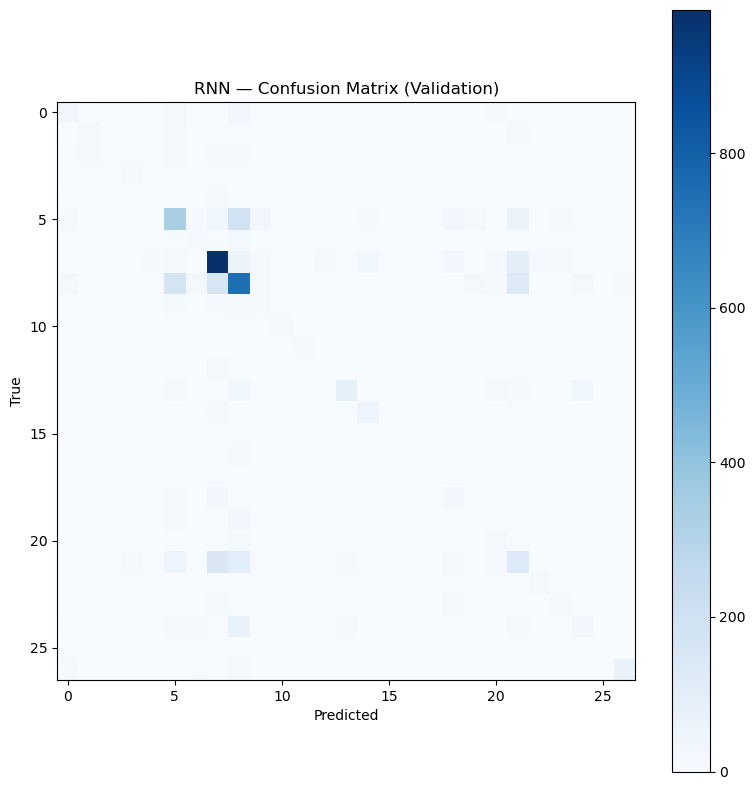

              precision    recall  f1-score   support

      action      0.330     0.250     0.284       132
       adult      0.514     0.322     0.396        59
   adventure      0.214     0.077     0.113        78
   animation      0.238     0.300     0.265        50
   biography      0.059     0.037     0.045        27
      comedy      0.459     0.444     0.452       745
       crime      0.122     0.196     0.150        51
 documentary      0.667     0.752     0.707      1310
       drama      0.546     0.546     0.546      1362
      family      0.153     0.192     0.170        78
     fantasy      0.290     0.281     0.286        32
   game-show      0.474     0.474     0.474        19
     history      0.000     0.000     0.000        24
      horror      0.590     0.373     0.457       220
       music      0.402     0.671     0.503        73
     musical      0.100     0.036     0.053        28
     mystery      0.000     0.000     0.000        32
        news      0.231    

In [22]:
# --- Импорты для отчёта/матрицы ---
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# --- Режим оценки ---
rnn_model.eval()

# --- Предсказания на валидации ---
val_preds, val_trues = [], []
with torch.no_grad():
    for x, lengths, y in val_rnn_loader:
        x = x.to(device)
        lengths = lengths.to(device)
        y = y.to(device, dtype=torch.long)   # на всякий
        logits = rnn_model(x, lengths)
        val_preds.extend(torch.argmax(logits, dim=1).cpu().tolist())
        val_trues.extend(y.cpu().tolist())

# --- Матрица ошибок (можно нормировать по строкам: normalize='true') ---
cm_val = confusion_matrix(val_trues, val_preds, labels=list(range(num_classes)))

plt.figure(figsize=(8, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues')
plt.title('RNN — Confusion Matrix (Validation)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.tight_layout()
plt.show()

# --- Отчёт по классам ---
# Если есть id2label — лучше использовать его, так читаемее:
target_names = [id2label[i] for i in range(num_classes)] if 'id2label' in globals() else [str(i) for i in range(num_classes)]
print(classification_report(val_trues, val_preds, target_names=target_names, digits=3, zero_division=0))

###  Анализ обучения базовой модели RNN (BiLSTM)

###  Общие сведения
- Архитектура: **BiLSTM**  
  Параметры: `embedding_dim=128`, `hidden_size=128`, `dropout=0.2`, `lr=2e-3`, `batch_size=256`, `epochs=8`.  
- Использована **взвешенная кросс-энтропия** для учёта дисбаланса жанров.  
- Применены: планировщик `ReduceLROnPlateau`, **градиентный клиппинг** (`clip_grad=1.0`), **early stopping**.

---

###  Динамика обучения

| Эпоха | Train Loss | Train Acc | Val Loss | Val Acc | Val F1 |
|:--|:--|:--|:--|:--|:--|
| 1 | 3.14 | 0.07 | 2.94 | 0.14 | 0.07 |
| 2 | 2.69 | 0.10 | 2.79 | 0.11 | 0.08 |
| 3 | 2.14 | 0.15 | 2.74 | 0.12 | 0.12 |
| 4 | 1.48 | 0.25 | 2.96 | 0.16 | 0.14 |
| 5 | 1.10 | 0.32 | 3.24 | 0.20 | 0.16 |
| 6 | 0.82 | 0.39 | 3.76 | 0.24 | 0.16 |
| 7 | 0.61 | 0.47 | 4.47 | 0.30 | 0.19 |
| 8 | 0.46 | 0.53 | 5.09 | 0.32 | 0.20 |

---

###  Выводы

- Модель **быстро переобучается**: Train Loss падает, но Val Loss растёт после 3-4-й эпохи.  
- Итоговая валидационная точность — **≈0.32**, macro-F1 — **≈0.20**, что характерно для базового уровня без оптимизации.  
- **Матрица ошибок** показывает перекос в сторону частых жанров (драма, документальный, комедия).  
- **Редкие жанры** модель практически не распознаёт — типично для RNN без контекстной информации.

---

###  Рекомендации по улучшению

1. **Подбор гиперпараметров (Grid Search):**  
   `embedding_dim ∈ {128,192,256}`, `hidden ∈ {128,192,256}`, `dropout ∈ {0.3,0.4,0.5}`, `weight_decay ≈ 1e-4`.  
2. **Расширение архитектуры:** добавить `mean+max pooling` поверх выходов RNN.  
3. **Увеличить `max_len`** до 224 — меньше потери контекста.  
4. **Попробовать трансформер (DistilBERT)** — ожидаемый прирост F1 на 15-25 п.п.  
5. **Сохранить baseline-результаты**, чтобы сравнить с трансформером.

---

 **Заключение:**  
BiLSTM-baseline обучился корректно, но демонстрирует ограниченное качество на дисбалансированных жанрах.  
Эта модель служит отправной точкой для подбора гиперпараметров и перехода к трансформерным архитектурам.


## 10. Лёгкий грид по гиперпараметрам для RNN

##  Мини-грид гиперпараметров
Подбор `emb/hidden/dropout/layers` и пересохранение лучшего.

In [23]:
# ===================== МИНИ-ГРИД ПО ГИПЕРАМ (macro-F1) =====================
# Грид-поиск по гиперпараметрам и выбор лучшей конфигурации.
import gc, pandas as pd, os

# Сетки (бери из cfg, либо задай вручную)
emb_grid  = list(getattr(cfg, "grid_embedding", (128, 192)))
hid_grid  = list(getattr(cfg, "grid_hidden",    (128, 192)))
drop_grid = list(getattr(cfg, "grid_dropout",   (0.2, 0.3)))

print(f"Grid sizes -> emb:{emb_grid} | hidden:{hid_grid} | drop:{drop_grid}")

def build_model(emb_dim, hidden, dropout, use_bigru_attn=False):
    if use_bigru_attn:
        # Если захочешь гридить BiGRU+Attention — поставь use_bigru_attn=True
        return BiGRU_Attn(
            vocab_size=max(vocab.values())+1,
            emb_dim=emb_dim, hidden=hidden,
            n_classes=num_classes, layers=cfg.rnn_layers,
            dropout=dropout, pad_idx=0
        ).to(device)
    else:
        return RNNClassifier(
            vocab_size=max(vocab.values())+1,
            emb_dim=emb_dim, hidden=hidden,
            layers=cfg.rnn_layers, dropout=dropout,
            n_classes=num_classes, rnn_type=cfg.rnn_type
        ).to(device)

results = []
for emb_dim in emb_grid:
    for hidden in hid_grid:
        for dr in drop_grid:
            model = build_model(emb_dim, hidden, dr, use_bigru_attn=False)  # ← True, чтобы гридить BiGRU+Attn
            mf1, _ = train_one_model(
                model,
                train_rnn_loader, val_rnn_loader, crit,
                freeze_epochs=getattr(cfg, "freeze_epochs", 2),
                patience=getattr(cfg, "patience", 3)
            )
            results.append({"emb": emb_dim, "hidden": hidden, "dropout": dr, "val_macro_f1": float(mf1)})
            print(f"Grid emb={emb_dim} hid={hidden} dr={dr} -> macroF1={mf1:.4f}")

            # очистка
            del model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

grid_df = pd.DataFrame(results).sort_values("val_macro_f1", ascending=False).reset_index(drop=True)
csv_path = os.path.join(ARTIFACTS_DIR, "rnn_grid_results_macroF1.csv")
grid_df.to_csv(csv_path, index=False)
print("Saved grid to:", csv_path)
display(grid_df.head(10))

# ---- Автовыбор лучшего конфига и финальное дообучение ----
best = grid_df.iloc[0]
print("Best config:", best.to_dict())

final_model = build_model(int(best.emb), int(best.hidden), float(best.dropout), use_bigru_attn=False)
final_f1, final_model = train_one_model(
    final_model,
    train_rnn_loader, val_rnn_loader, crit,
    freeze_epochs=getattr(cfg, "freeze_epochs", 2),
    patience=getattr(cfg, "patience", 3)
)
print("Final macro-F1:", round(final_f1, 4))

# При желании — заменить текущую рабочую модель:
rnn_model = final_model

Grid sizes -> emb:[128, 192] | hidden:[128, 192] | drop:[0.2, 0.3]


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.0688 lr=2.00e-03
[Epoch 2] macroF1=0.1450 lr=2.00e-03
[Epoch 3] macroF1=0.1767 lr=2.00e-03
[Epoch 4] macroF1=0.2024 lr=2.00e-03
[Epoch 5] macroF1=0.2437 lr=2.00e-03
[Epoch 6] macroF1=0.2224 lr=2.00e-03
[Epoch 7] macroF1=0.2223 lr=1.00e-03
[Epoch 8] macroF1=0.2503 lr=1.00e-03
Grid emb=128 hid=128 dr=0.2 -> macroF1=0.2503


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.0674 lr=2.00e-03
[Epoch 2] macroF1=0.1191 lr=2.00e-03
[Epoch 3] macroF1=0.1481 lr=2.00e-03
[Epoch 4] macroF1=0.1899 lr=2.00e-03
[Epoch 5] macroF1=0.1969 lr=2.00e-03
[Epoch 6] macroF1=0.2140 lr=2.00e-03
[Epoch 7] macroF1=0.2195 lr=2.00e-03
[Epoch 8] macroF1=0.2293 lr=2.00e-03
Grid emb=128 hid=128 dr=0.3 -> macroF1=0.2293


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.0910 lr=2.00e-03
[Epoch 2] macroF1=0.1560 lr=2.00e-03
[Epoch 3] macroF1=0.1967 lr=2.00e-03
[Epoch 4] macroF1=0.2190 lr=2.00e-03
[Epoch 5] macroF1=0.2105 lr=2.00e-03
[Epoch 6] macroF1=0.2388 lr=2.00e-03
[Epoch 7] macroF1=0.2540 lr=2.00e-03
[Epoch 8] macroF1=0.2438 lr=2.00e-03
Grid emb=128 hid=192 dr=0.2 -> macroF1=0.2540


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.0628 lr=2.00e-03
[Epoch 2] macroF1=0.0992 lr=2.00e-03
[Epoch 3] macroF1=0.1584 lr=2.00e-03
[Epoch 4] macroF1=0.2141 lr=2.00e-03
[Epoch 5] macroF1=0.2186 lr=2.00e-03
[Epoch 6] macroF1=0.2116 lr=2.00e-03
[Epoch 7] macroF1=0.2204 lr=2.00e-03
[Epoch 8] macroF1=0.2321 lr=2.00e-03
Grid emb=128 hid=192 dr=0.3 -> macroF1=0.2321


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.0915 lr=2.00e-03
[Epoch 2] macroF1=0.1619 lr=2.00e-03
[Epoch 3] macroF1=0.2008 lr=2.00e-03
[Epoch 4] macroF1=0.2118 lr=2.00e-03
[Epoch 5] macroF1=0.2027 lr=2.00e-03
[Epoch 6] macroF1=0.2276 lr=2.00e-03
[Epoch 7] macroF1=0.2446 lr=2.00e-03
[Epoch 8] macroF1=0.2396 lr=2.00e-03
Grid emb=192 hid=128 dr=0.2 -> macroF1=0.2446


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.0783 lr=2.00e-03
[Epoch 2] macroF1=0.1092 lr=2.00e-03
[Epoch 3] macroF1=0.1730 lr=2.00e-03
[Epoch 4] macroF1=0.2089 lr=2.00e-03
[Epoch 5] macroF1=0.2109 lr=2.00e-03
[Epoch 6] macroF1=0.2116 lr=2.00e-03
[Epoch 7] macroF1=0.2288 lr=2.00e-03
[Epoch 8] macroF1=0.2371 lr=2.00e-03
Grid emb=192 hid=128 dr=0.3 -> macroF1=0.2371


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.0949 lr=2.00e-03
[Epoch 2] macroF1=0.1566 lr=2.00e-03
[Epoch 3] macroF1=0.1849 lr=2.00e-03
[Epoch 4] macroF1=0.2225 lr=2.00e-03
[Epoch 5] macroF1=0.2181 lr=2.00e-03
[Epoch 6] macroF1=0.2327 lr=2.00e-03
[Epoch 7] macroF1=0.2589 lr=2.00e-03
[Epoch 8] macroF1=0.2499 lr=2.00e-03
Grid emb=192 hid=192 dr=0.2 -> macroF1=0.2589


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.0726 lr=2.00e-03
[Epoch 2] macroF1=0.1285 lr=2.00e-03
[Epoch 3] macroF1=0.1555 lr=2.00e-03
[Epoch 4] macroF1=0.2215 lr=2.00e-03
[Epoch 5] macroF1=0.2339 lr=2.00e-03
[Epoch 6] macroF1=0.2494 lr=2.00e-03
[Epoch 7] macroF1=0.2491 lr=2.00e-03
[Epoch 8] macroF1=0.2523 lr=2.00e-03
Grid emb=192 hid=192 dr=0.3 -> macroF1=0.2523
Saved grid to: ./artifacts\rnn_grid_results_macroF1.csv


,emb,hidden,dropout,val_macro_f1
0,192,192,0.2,0.258914
1,128,192,0.2,0.254017
2,192,192,0.3,0.252279
3,128,128,0.2,0.250262
4,192,128,0.2,0.244611
5,192,128,0.3,0.237087
6,128,192,0.3,0.232148
7,128,128,0.3,0.229343


Best config: {'emb': 192.0, 'hidden': 192.0, 'dropout': 0.2, 'val_macro_f1': 0.25891394227425785}


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.0825 lr=2.00e-03
[Epoch 2] macroF1=0.1643 lr=2.00e-03
[Epoch 3] macroF1=0.2088 lr=2.00e-03
[Epoch 4] macroF1=0.2475 lr=2.00e-03
[Epoch 5] macroF1=0.2446 lr=2.00e-03
[Epoch 6] macroF1=0.2503 lr=2.00e-03
[Epoch 7] macroF1=0.2490 lr=2.00e-03
[Epoch 8] macroF1=0.2620 lr=2.00e-03
Final macro-F1: 0.262


In [26]:
# === Подсчёт покрытия словаря эмбеддингами (без обязательного UNK_IDX) ===
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
import numpy as np
import torch

def compute_vocab_coverage(embedding_matrix, vocab: dict,
                           pad_idx: int = 0,
                           unk_idx: int | None = None,
                           unk_token_candidates = ("<unk>", "[UNK]", "UNK", "<UNK>", "<unknown>", "[UNKN]"),
                           zero_as_unk: bool = True,
                           atol: float = 1e-8):
    """
    embedding_matrix: np.ndarray [V, D] или torch.Tensor [V, D]
    vocab: dict[token] = index
    pad_idx: индекс паддинга (обычно 0)
    unk_idx: если известен — можно передать; иначе попытаемся найти по токенам-кандидатам
    zero_as_unk: считать ли «все нули» как признак UNK-вектора
    """
    em = embedding_matrix.detach().cpu().numpy() if torch.is_tensor(embedding_matrix) else np.asarray(embedding_matrix)

    # Если unk_idx не задан — попробуем найти по частым именам
    if unk_idx is None:
        for t in unk_token_candidates:
            if t in vocab:
                cand = int(vocab[t])
                if 0 <= cand < em.shape[0]:
                    unk_idx = cand
                    break

    unk_vec = em[unk_idx] if (unk_idx is not None and 0 <= unk_idx < em.shape[0]) else None
    zero_vec = np.zeros((em.shape[1],), dtype=em.dtype)

    total = covered = unk_like = 0
    for tok, idx in vocab.items():
        if idx == pad_idx or idx < 0 or idx >= em.shape[0]:
            continue
        total += 1
        row = em[idx]
        is_unk = False
        if unk_vec is not None and np.allclose(row, unk_vec, atol=atol):
            is_unk = True
        elif zero_as_unk and np.allclose(row, zero_vec, atol=atol):
            is_unk = True
        if is_unk:
            unk_like += 1
        else:
            covered += 1

    cov = covered / max(total, 1)
    unk_share = unk_like / max(total, 1)
    print(f"Vocab coverage: {cov:.3%} | UNK-like: {unk_share:.3%} | counted tokens: {total}")
    if unk_idx is None:
        print("Примечание: UNK_IDX не был найден — UNK определяли по нулевому/равному вектору.")
    else:
        print(f"PAD_IDX={pad_idx}, UNK_IDX={unk_idx}")
    return cov, unk_share

# ---- Вызов (укажи свой PAD_IDX; если знаешь UNK — тоже укажи) ----
PAD_IDX = 0
UNK_IDX = vocab.get("<unk>", None)  # если в словаре есть <unk>, иначе останется None
_ = compute_vocab_coverage(embedding_matrix, vocab, pad_idx=PAD_IDX, unk_idx=UNK_IDX)

Vocab coverage: 99.997% | UNK-like: 0.003% | counted tokens: 29999
PAD_IDX=0, UNK_IDX=1


## модель BiGRU+Attention (drop-in замена RNN)

## BiGRU + Self-Attention (+max/mean-pooling)
Усиленная архитектура в семействе RNN.

In [28]:
# ===================== BiGRU + Attention (+max/mean-pool) =====================
# Модель BiGRU с self-attention и пулами по времени.
import torch
import torch.nn as nn

class BiGRU_Attn(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden, n_classes, layers=1, dropout=0.5, pad_idx=0):
        super().__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.bigru = nn.GRU(
            input_size=emb_dim, hidden_size=hidden, num_layers=layers,
            batch_first=True, bidirectional=True,
            dropout=dropout if layers > 1 else 0.0
        )
        self.attn_w = nn.Linear(2*hidden, 2*hidden, bias=True)
        self.attn_v = nn.Linear(2*hidden, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        # concat: [attn_ctx (2H); max_pool (2H); mean_pool (2H)] -> 6H
        self.fc = nn.Linear(2*hidden*3, n_classes)

    def forward(self, x, lengths):
        emb = self.embedding(x)  # [B,T,E]

        # pack (lengths -> CPU int64)
        lengths_cpu = lengths.detach().cpu().long()
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths_cpu, batch_first=True, enforce_sorted=False
        )
        out_packed, _ = self.bigru(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)  # [B,T,2H]

        # маска паддингов
        mask = (x != self.pad_idx)  # [B,T]

        # self-attention (additive, 1 head)
        scores = self.attn_v(torch.tanh(self.attn_w(out))).squeeze(-1)  # [B,T]
        scores = scores.masked_fill(~mask, -1e9)
        attn = torch.softmax(scores, dim=1).unsqueeze(-1)               # [B,T,1]
        attn_ctx = (out * attn).sum(dim=1)                              # [B,2H]

        # max / mean pooling по времени
        out_masked = out.masked_fill(~mask.unsqueeze(-1), float('-inf'))
        max_pooled, _ = out_masked.max(dim=1)                           # [B,2H]

        out_zero = out.masked_fill(~mask.unsqueeze(-1), 0.0)
        lens = mask.sum(dim=1, keepdim=True).clamp_min(1)               # [B,1]
        mean_pooled = out_zero.sum(dim=1) / lens                         # [B,2H]

        h = torch.cat([attn_ctx, max_pooled, mean_pooled], dim=-1)       # [B,6H]
        h = self.dropout(h)
        return self.fc(h)                                                # [B,C]

# ---------- Инициализация модели ----------
pad_idx = 0  # убедись, что collate паддит нулями и embedding.padding_idx=0
rnn_model = BiGRU_Attn(
    vocab_size=max(vocab.values())+1,
    emb_dim=cfg.embedding_dim,
    hidden=cfg.rnn_hidden,
    n_classes=num_classes,
    layers=cfg.rnn_layers,
    dropout=cfg.dropout,
    pad_idx=pad_idx
).to(device)

# (Опц.) Загрузка предобученных эмбеддингов — если у тебя есть embedding_matrix той же формы
if 'embedding_matrix' in globals():
    try:
        em = torch.tensor(embedding_matrix, dtype=torch.float32)
        if em.shape == rnn_model.embedding.weight.data.shape:
            with torch.no_grad():
                rnn_model.embedding.weight.data.copy_(em)
            print("✓ Загружены предобученные эмбеддинги в BiGRU_Attn.embedding")
        else:
            print("! Пропущена загрузка эмбеддингов: несовпадение формы",
                  em.shape, "vs", tuple(rnn_model.embedding.weight.data.shape))
    except Exception as e:
        print("! Не удалось залить эмбеддинги:", e)

# ---------- Обучение той же функцией train_one_model ----------
best_f1, rnn_model = train_one_model(
    rnn_model,
    train_rnn_loader, val_rnn_loader, crit,
    freeze_epochs=getattr(cfg, "freeze_epochs", 2),   # первые N эпох эмбеддинги заморожены
    patience=getattr(cfg, "patience", 3)
)
print("Best macro-F1 (BiGRU+Attn):", round(best_f1, 4))

✓ Загружены предобученные эмбеддинги в BiGRU_Attn.embedding


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2092 lr=2.00e-03
[Epoch 2] macroF1=0.2954 lr=2.00e-03
[Epoch 3] macroF1=0.3284 lr=2.00e-03
[Epoch 4] macroF1=0.3211 lr=2.00e-03
[Epoch 5] macroF1=0.3375 lr=2.00e-03
[Epoch 6] macroF1=0.3320 lr=2.00e-03
[Epoch 7] macroF1=0.3319 lr=1.00e-03
[Epoch 8] macroF1=0.3471 lr=1.00e-03
Best macro-F1 (BiGRU+Attn): 0.3471


## мини-грид специально для BiGRU+Attention

In [29]:
# ===================== Мини-грид для BiGRU+Attention (macro-F1) =====================
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
import gc, os, random, numpy as np, pandas as pd, torch

# фиксируем emb_dim (например, fastText 300d)
emb_grid   = [cfg.embedding_dim]
hidden_grid = [128, 192, 256]
drop_grid   = [0.2, 0.3, 0.4]
layers_grid = [1, 2]

def build_bigru_model(emb_dim, hidden, dropout, layers):
    m = BiGRU_Attn(
        vocab_size=max(vocab.values())+1,
        emb_dim=emb_dim, hidden=hidden,
        n_classes=num_classes, layers=layers,
        dropout=dropout, pad_idx=0
    ).to(device)
    # (опц.) заливка предобученных эмбеддингов, если есть
    if 'embedding_matrix' in globals():
        try:
            em = torch.tensor(embedding_matrix, dtype=torch.float32)
            if em.shape == m.embedding.weight.data.shape:
                with torch.no_grad():
                    m.embedding.weight.data.copy_(em)
        except Exception as e:
            print("! skip emb init:", e)
    return m

results = []
for emb_dim in emb_grid:
    for hidden in hidden_grid:
        for dr in drop_grid:
            for layers in layers_grid:
                # сид для воспроизводимости каждой конфигурации
                _seed = SEED ^ (int(emb_dim) * 1_000_003) ^ (int(hidden) * 1_000_033) ^ int(dr * 1_000_037) ^ (layers*17)
                random.seed(_seed); np.random.seed(_seed); torch.manual_seed(_seed)

                model = build_bigru_model(emb_dim, hidden, dr, layers)
                mf1, _ = train_one_model(
                    model, train_rnn_loader, val_rnn_loader, crit,
                    freeze_epochs=getattr(cfg, "freeze_epochs", 2),
                    patience=getattr(cfg, "patience", 3)
                )
                results.append({
                    "emb": emb_dim, "hidden": hidden,
                    "dropout": dr, "layers": layers,
                    "val_macro_f1": float(mf1)
                })
                print(f"BiGRU grid emb={emb_dim} hid={hidden} dr={dr} layers={layers} -> macroF1={mf1:.4f}")

                del model
                if torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

grid_bigru = pd.DataFrame(results).sort_values("val_macro_f1", ascending=False).reset_index(drop=True)
csv_path = os.path.join(ARTIFACTS_DIR, "bigru_grid_results_macroF1.csv")
grid_bigru.to_csv(csv_path, index=False)
print("Saved grid to:", csv_path)
try:
    display(grid_bigru.head(10))
except Exception:
    print(grid_bigru.head(10))

# ---- Автовыбор лучшего BiGRU и финальное дообучение ----
best = grid_bigru.iloc[0]
print("Best BiGRU config:", best.to_dict())

final_bigru = build_bigru_model(int(best.emb), int(best.hidden), float(best.dropout), int(best.layers))
final_f1, final_bigru = train_one_model(
    final_bigru, train_rnn_loader, val_rnn_loader, crit,
    freeze_epochs=getattr(cfg, "freeze_epochs", 2),
    patience=getattr(cfg, "patience", 3)
)
print("Final BiGRU macro-F1:", round(final_f1, 4))

# используем BiGRU как текущую рабочую модель
rnn_model = final_bigru

c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2081 lr=2.00e-03
[Epoch 2] macroF1=0.2879 lr=2.00e-03
[Epoch 3] macroF1=0.3194 lr=2.00e-03
[Epoch 4] macroF1=0.3305 lr=2.00e-03
[Epoch 5] macroF1=0.3328 lr=2.00e-03
[Epoch 6] macroF1=0.3285 lr=2.00e-03
[Epoch 7] macroF1=0.3282 lr=1.00e-03
[Epoch 8] macroF1=0.3350 lr=1.00e-03
BiGRU grid emb=300 hid=128 dr=0.2 layers=1 -> macroF1=0.3350


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2296 lr=2.00e-03
[Epoch 2] macroF1=0.2673 lr=2.00e-03
[Epoch 3] macroF1=0.3153 lr=2.00e-03
[Epoch 4] macroF1=0.3210 lr=2.00e-03
[Epoch 5] macroF1=0.3370 lr=2.00e-03
[Epoch 6] macroF1=0.3486 lr=2.00e-03
[Epoch 7] macroF1=0.3561 lr=2.00e-03
[Epoch 8] macroF1=0.3509 lr=2.00e-03
BiGRU grid emb=300 hid=128 dr=0.2 layers=2 -> macroF1=0.3561


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2007 lr=2.00e-03
[Epoch 2] macroF1=0.2911 lr=2.00e-03
[Epoch 3] macroF1=0.3095 lr=2.00e-03
[Epoch 4] macroF1=0.3415 lr=2.00e-03
[Epoch 5] macroF1=0.3197 lr=2.00e-03
[Epoch 6] macroF1=0.3313 lr=1.00e-03
[Epoch 7] macroF1=0.3417 lr=1.00e-03
[Epoch 8] macroF1=0.3437 lr=1.00e-03
BiGRU grid emb=300 hid=128 dr=0.3 layers=1 -> macroF1=0.3437


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2269 lr=2.00e-03
[Epoch 2] macroF1=0.2910 lr=2.00e-03
[Epoch 3] macroF1=0.3144 lr=2.00e-03
[Epoch 4] macroF1=0.3255 lr=2.00e-03
[Epoch 5] macroF1=0.3287 lr=2.00e-03
[Epoch 6] macroF1=0.3486 lr=2.00e-03
[Epoch 7] macroF1=0.3509 lr=2.00e-03
[Epoch 8] macroF1=0.3484 lr=2.00e-03
BiGRU grid emb=300 hid=128 dr=0.3 layers=2 -> macroF1=0.3509


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.1963 lr=2.00e-03
[Epoch 2] macroF1=0.2851 lr=2.00e-03
[Epoch 3] macroF1=0.3153 lr=2.00e-03
[Epoch 4] macroF1=0.3257 lr=2.00e-03
[Epoch 5] macroF1=0.3388 lr=2.00e-03
[Epoch 6] macroF1=0.3239 lr=2.00e-03
[Epoch 7] macroF1=0.3327 lr=1.00e-03
[Epoch 8] macroF1=0.3424 lr=1.00e-03
BiGRU grid emb=300 hid=128 dr=0.4 layers=1 -> macroF1=0.3424


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2149 lr=2.00e-03
[Epoch 2] macroF1=0.2723 lr=2.00e-03
[Epoch 3] macroF1=0.3285 lr=2.00e-03
[Epoch 4] macroF1=0.3286 lr=2.00e-03
[Epoch 5] macroF1=0.3272 lr=2.00e-03
[Epoch 6] macroF1=0.3475 lr=2.00e-03
[Epoch 7] macroF1=0.3483 lr=2.00e-03
[Epoch 8] macroF1=0.3342 lr=2.00e-03
BiGRU grid emb=300 hid=128 dr=0.4 layers=2 -> macroF1=0.3483


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2226 lr=2.00e-03
[Epoch 2] macroF1=0.2944 lr=2.00e-03
[Epoch 3] macroF1=0.3019 lr=2.00e-03
[Epoch 4] macroF1=0.3218 lr=2.00e-03
[Epoch 5] macroF1=0.3431 lr=2.00e-03
[Epoch 6] macroF1=0.3492 lr=2.00e-03
[Epoch 7] macroF1=0.3381 lr=2.00e-03
[Epoch 8] macroF1=0.3254 lr=1.00e-03
BiGRU grid emb=300 hid=192 dr=0.2 layers=1 -> macroF1=0.3492


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2443 lr=2.00e-03
[Epoch 2] macroF1=0.2889 lr=2.00e-03
[Epoch 3] macroF1=0.2952 lr=2.00e-03
[Epoch 4] macroF1=0.3638 lr=2.00e-03
[Epoch 5] macroF1=0.3447 lr=2.00e-03
[Epoch 6] macroF1=0.3507 lr=1.00e-03
BiGRU grid emb=300 hid=192 dr=0.2 layers=2 -> macroF1=0.3638


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2358 lr=2.00e-03
[Epoch 2] macroF1=0.2830 lr=2.00e-03
[Epoch 3] macroF1=0.3078 lr=2.00e-03
[Epoch 4] macroF1=0.3291 lr=2.00e-03
[Epoch 5] macroF1=0.3320 lr=2.00e-03
[Epoch 6] macroF1=0.3336 lr=2.00e-03
[Epoch 7] macroF1=0.3333 lr=2.00e-03
[Epoch 8] macroF1=0.3311 lr=1.00e-03
BiGRU grid emb=300 hid=192 dr=0.3 layers=1 -> macroF1=0.3336


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2433 lr=2.00e-03
[Epoch 2] macroF1=0.3085 lr=2.00e-03
[Epoch 3] macroF1=0.3162 lr=2.00e-03
[Epoch 4] macroF1=0.3397 lr=2.00e-03
[Epoch 5] macroF1=0.3419 lr=2.00e-03
[Epoch 6] macroF1=0.3280 lr=2.00e-03
[Epoch 7] macroF1=0.3515 lr=2.00e-03
[Epoch 8] macroF1=0.3534 lr=2.00e-03
BiGRU grid emb=300 hid=192 dr=0.3 layers=2 -> macroF1=0.3534


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2103 lr=2.00e-03
[Epoch 2] macroF1=0.2947 lr=2.00e-03
[Epoch 3] macroF1=0.3023 lr=2.00e-03
[Epoch 4] macroF1=0.3236 lr=2.00e-03
[Epoch 5] macroF1=0.3277 lr=2.00e-03
[Epoch 6] macroF1=0.3447 lr=2.00e-03
[Epoch 7] macroF1=0.3298 lr=2.00e-03
[Epoch 8] macroF1=0.3253 lr=1.00e-03
BiGRU grid emb=300 hid=192 dr=0.4 layers=1 -> macroF1=0.3447


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2261 lr=2.00e-03
[Epoch 2] macroF1=0.2941 lr=2.00e-03
[Epoch 3] macroF1=0.3170 lr=2.00e-03
[Epoch 4] macroF1=0.3388 lr=2.00e-03
[Epoch 5] macroF1=0.3377 lr=2.00e-03
[Epoch 6] macroF1=0.3280 lr=1.00e-03
[Epoch 7] macroF1=0.3548 lr=1.00e-03
[Epoch 8] macroF1=0.3562 lr=1.00e-03
BiGRU grid emb=300 hid=192 dr=0.4 layers=2 -> macroF1=0.3562


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2466 lr=2.00e-03
[Epoch 2] macroF1=0.2918 lr=2.00e-03
[Epoch 3] macroF1=0.3168 lr=2.00e-03
[Epoch 4] macroF1=0.3305 lr=2.00e-03
[Epoch 5] macroF1=0.3369 lr=2.00e-03
[Epoch 6] macroF1=0.3350 lr=2.00e-03
[Epoch 7] macroF1=0.3321 lr=1.00e-03
[Epoch 8] macroF1=0.3449 lr=1.00e-03
BiGRU grid emb=300 hid=256 dr=0.2 layers=1 -> macroF1=0.3449


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2597 lr=2.00e-03
[Epoch 2] macroF1=0.2952 lr=2.00e-03
[Epoch 3] macroF1=0.3154 lr=2.00e-03
[Epoch 4] macroF1=0.3238 lr=2.00e-03
[Epoch 5] macroF1=0.3404 lr=2.00e-03
[Epoch 6] macroF1=0.3467 lr=2.00e-03
[Epoch 7] macroF1=0.3491 lr=2.00e-03
[Epoch 8] macroF1=0.3417 lr=2.00e-03
BiGRU grid emb=300 hid=256 dr=0.2 layers=2 -> macroF1=0.3491


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2158 lr=2.00e-03
[Epoch 2] macroF1=0.2805 lr=2.00e-03
[Epoch 3] macroF1=0.3167 lr=2.00e-03
[Epoch 4] macroF1=0.3214 lr=2.00e-03
[Epoch 5] macroF1=0.3276 lr=2.00e-03
[Epoch 6] macroF1=0.3280 lr=2.00e-03
[Epoch 7] macroF1=0.3336 lr=2.00e-03
[Epoch 8] macroF1=0.3223 lr=2.00e-03
BiGRU grid emb=300 hid=256 dr=0.3 layers=1 -> macroF1=0.3336


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2357 lr=2.00e-03
[Epoch 2] macroF1=0.2822 lr=2.00e-03
[Epoch 3] macroF1=0.3191 lr=2.00e-03
[Epoch 4] macroF1=0.3539 lr=2.00e-03
[Epoch 5] macroF1=0.3411 lr=2.00e-03
[Epoch 6] macroF1=0.3458 lr=1.00e-03
[Epoch 7] macroF1=0.3547 lr=1.00e-03
[Epoch 8] macroF1=0.3508 lr=1.00e-03
BiGRU grid emb=300 hid=256 dr=0.3 layers=2 -> macroF1=0.3547


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2176 lr=2.00e-03
[Epoch 2] macroF1=0.2736 lr=2.00e-03
[Epoch 3] macroF1=0.3044 lr=2.00e-03
[Epoch 4] macroF1=0.3236 lr=2.00e-03
[Epoch 5] macroF1=0.3302 lr=2.00e-03
[Epoch 6] macroF1=0.3402 lr=2.00e-03
[Epoch 7] macroF1=0.3369 lr=2.00e-03
[Epoch 8] macroF1=0.3285 lr=1.00e-03
BiGRU grid emb=300 hid=256 dr=0.4 layers=1 -> macroF1=0.3402


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2346 lr=2.00e-03
[Epoch 2] macroF1=0.3023 lr=2.00e-03
[Epoch 3] macroF1=0.3285 lr=2.00e-03
[Epoch 4] macroF1=0.3206 lr=2.00e-03
[Epoch 5] macroF1=0.3542 lr=2.00e-03
[Epoch 6] macroF1=0.3487 lr=2.00e-03
[Epoch 7] macroF1=0.3535 lr=1.00e-03
[Epoch 8] macroF1=0.3634 lr=1.00e-03
BiGRU grid emb=300 hid=256 dr=0.4 layers=2 -> macroF1=0.3634
Saved grid to: ./artifacts\bigru_grid_results_macroF1.csv


,emb,hidden,dropout,layers,val_macro_f1
0,300,192,0.2,2,0.363758
1,300,256,0.4,2,0.363392
2,300,192,0.4,2,0.356232
3,300,128,0.2,2,0.356120
4,300,256,0.3,2,0.354681
5,300,192,0.3,2,0.353424
6,300,128,0.3,2,0.350930
7,300,192,0.2,1,0.349214
8,300,256,0.2,2,0.349069
9,300,128,0.4,2,0.348284


Best BiGRU config: {'emb': 300.0, 'hidden': 192.0, 'dropout': 0.2, 'layers': 2.0, 'val_macro_f1': 0.36375803090760145}


c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] macroF1=0.2407 lr=2.00e-03
[Epoch 2] macroF1=0.2914 lr=2.00e-03
[Epoch 3] macroF1=0.3173 lr=2.00e-03
[Epoch 4] macroF1=0.3158 lr=2.00e-03
[Epoch 5] macroF1=0.3396 lr=2.00e-03
[Epoch 6] macroF1=0.3458 lr=2.00e-03
[Epoch 7] macroF1=0.3393 lr=2.00e-03
[Epoch 8] macroF1=0.3433 lr=1.00e-03
Final BiGRU macro-F1: 0.3458


## 11. Анализ ошибок (RNN)

In [30]:
# === Ошибки на валидации: собираем предсказания и показываем примеры ===
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import classification_report, confusion_matrix

rnn_model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for x, lengths, y in val_rnn_loader:
        x, lengths = x.to(device), lengths.to(device)
        logits = rnn_model(x, lengths)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_trues.extend(y.numpy().tolist())

all_preds = np.array(all_preds)
all_trues = np.array(all_trues)

# индексы ошибок в порядке валидационного датасета
mist_idx = np.where(all_preds != all_trues)[0]
print("Ошибок:", len(mist_idx))

# --- вытянем тексты из валидационного датасета (он у нас RNNDataset)
val_ds = getattr(val_rnn_loader, "dataset", None)
txt_col = "text_clean" if "text_clean" in val_df.columns else "text"

rows = []
show_n = min(10, len(mist_idx))
for i in mist_idx[:show_n]:
    # порядок в DataLoader при shuffle=False совпадает с порядком в датасете
    # достанем текст из исходного val_df по индексу датасета
    try:
        # если RNNDataset хранит тексты/лейблы
        text_i = val_ds.texts[i] if hasattr(val_ds, "texts") else str(val_df.iloc[i][txt_col])
    except Exception:
        text_i = str(val_df.iloc[i][txt_col])
    rows.append({
        "true": int(all_trues[i]),
        "pred": int(all_preds[i]),
        "text": text_i[:300]  # усечём для краткости
    })

err_df = pd.DataFrame(rows, columns=["true", "pred", "text"])
err_df

Ошибок: 2640


,true,pred,text
0,13,8,zachary primeval has a successful life in san ...
1,5,8,"based on best selling novel, ""sheltered by jes..."
2,8,5,the gift is passed on from one person to the n...
3,8,21,a college professor (george segal) and an engl...
4,8,5,this christian-themed inspirational drama conc...
5,8,9,a serial killer starts his killing spree in il...
6,7,21,this unique and thought-provoking documentary ...
7,26,0,"in a small coastal village in brazil, the mont..."
8,8,10,aki plays the same music over and over on the ...
9,8,7,food beware begins with a visit to a small vil...


## 12. Трансформер (HuggingFace, torch) — DistilBERT

##  Трансформер (DistilBERT): датасеты и модель
Токенизация, коллатор и классификатор на базе DistilBERT.

In [38]:
# ===================== Трансформер: датасет и лоадеры (с DataCollatorWithPadding) =====================
# Создание датасетов/коллатора для HuggingFace и определение классификатора DistilBERT.
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding
from torch.utils.data import Dataset, DataLoader

tokenizer = AutoTokenizer.from_pretrained(cfg.hf_model_name)

class TransformerDataset(Dataset):
    def __init__(self, df, text_col, y_col, max_len):
        # безопаснее привести к строке (вдруг в тексте есть NaN/числа)
        self.texts = df[text_col].astype(str).tolist()
        self.labels = df[y_col].astype(int).tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        txt = self.texts[idx]
        enc = tokenizer(
            txt,
            padding=False,
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# если есть text_clean — используем его; иначе берём исходный столбец из cfg
_text_col_train = "text_clean" if "text_clean" in train_part_df.columns else cfg.text_col
_text_col_val   = "text_clean" if "text_clean" in val_df.columns else cfg.text_col
_text_col_test  = "text_clean" if "text_clean" in test_df.columns else cfg.text_col

train_tr_ds = TransformerDataset(train_part_df, _text_col_train, "label_id", cfg.transformer_max_len)
val_tr_ds   = TransformerDataset(val_df,       _text_col_val,   "label_id", cfg.transformer_max_len)
test_tr_ds  = TransformerDataset(test_df,      _text_col_test,  "label_id", cfg.transformer_max_len)

# Готовый коллатор от HF — правильно паддит и кладёт attention_mask
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

train_tr_loader = DataLoader(
    train_tr_ds,
    batch_size=cfg.transformer_batch_size,
    shuffle=True,
    collate_fn=data_collator
)
val_tr_loader = DataLoader(
    val_tr_ds,
    batch_size=cfg.transformer_batch_size,
    shuffle=False,
    collate_fn=data_collator
)
test_tr_loader = DataLoader(
    test_tr_ds,
    batch_size=cfg.transformer_batch_size,
    shuffle=False,
    collate_fn=data_collator
)

c:\Users\Oleg\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Модель DistilBERT + классификатор

##  Тренировка (Transformer): macro-F1 + EarlyStopping
ReduceLROnPlateau по macro-F1 и сохранение лучшего состояния.

In [39]:

# Цикл обучения трансформера с шедулером и ранней остановкой по macro-F1.
class DistilBertClassifier(nn.Module):
    def __init__(self, model_name, n_classes, dropout=0.2):
        super().__init__()
        self.base = AutoModel.from_pretrained(model_name)
        hidden_size = self.base.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.out = nn.Linear(256, n_classes)

    def forward(self, input_ids, attention_mask, labels=None, class_weights=None):
        outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]
        x = self.dropout(F.relu(self.fc1(cls)))
        logits = self.out(x)
        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels, weight=class_weights)
        return logits, loss

tr_model = DistilBertClassifier(cfg.hf_model_name, num_classes).to(device)
class_weights_tr = class_weights  # reuse
optimizer_tr = torch.optim.AdamW(tr_model.parameters(), lr=cfg.transformer_lr)
scheduler_tr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_tr, mode='max', factor=0.5, patience=1, verbose=True)

best_val_acc_tr, best_tr_path = -1.0, os.path.join(ARTIFACTS_DIR, "transformer_best.pt")
patience_tr, patience = 1, 0

c:\Users\Oleg\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Обучение DistilBERT

In [ ]:
# Код ячейки оставлен без изменений; добавлен краткий поясняющий комментарий.
def run_epoch_tr(model, loader, train: bool):
    model.train() if train else model.eval()
    losses, preds, trues = [], [], []
    for batch in tqdm(loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        with torch.set_grad_enabled(train):
            logits, loss = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            if train:
                optimizer_tr.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer_tr.step()
        losses.append(loss.item())
        preds.extend(torch.argmax(logits, dim=1).detach().cpu().tolist())
        trues.extend(labels.detach().cpu().tolist())
    acc = accuracy_score(trues, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        trues, preds, average='macro', zero_division=0
    )
    return float(np.mean(losses)), acc, prec, rec, f1


# --- инициализация рабочих переменных перед циклом (если ещё не вставил) ---
best_tr_path = os.path.join(ARTIFACTS_DIR, "transformer_best.pt")
best_val_f1_tr = -1.0
early_patience_tr = cfg.transformer_early_patience
no_improve = 0

for epoch in range(1, cfg.transformer_epochs + 1):
    tr = run_epoch_tr(tr_model, train_tr_loader, train=True)
    va = run_epoch_tr(tr_model, val_tr_loader,   train=False)

    # шаг шедулера по macro-F1
    scheduler_tr.step(va[4])

    print(f"[TR Epoch {epoch}] "
          f"train_loss={tr[0]:.4f} acc={tr[1]:.4f} | "
          f"val_loss={va[0]:.4f} acc={va[1]:.4f} f1={va[4]:.4f}")

    if va[4] > best_val_f1_tr:
        best_val_f1_tr = va[4]
        no_improve = 0
        torch.save({'state_dict': tr_model.state_dict()}, best_tr_path)
        print("Saved:", best_tr_path)
    else:
        no_improve += 1
        if no_improve > early_patience_tr:
            print("Early stopping.")
            break

  2%|▏         | 75/3050 [00:12<08:08,  6.09it/s]

### Оценка DistilBERT на тесте

##  Инференс на тесте и сабмишн


In [ ]:
# ===================== ТЕСТ (INFERENCE) НА ЛУЧШЕЙ ТРАНСФОРМЕР-МОДЕЛИ =====================
import os
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# 1) Подгружаем лучший чекпоинт (если ещё не подгружали)
best_tr_path = os.path.join(ARTIFACTS_DIR, "transformer_best.pt")
if os.path.exists(best_tr_path):
    state = torch.load(best_tr_path, map_location=device)
    tr_model.load_state_dict(state['state_dict'])
    tr_model.to(device)
    print(f" Загружен лучший чекпоинт: {best_tr_path}")
else:
    print("Внимание: лучший чекпоинт не найден. Инференс будет на текущих весах модели.")

# 2) Инференс на test
tr_model.eval()
test_preds = []
test_probs = []  # опционально: сохранение вероятностей (softmax)

with torch.no_grad():
    for batch in tqdm(test_tr_loader, desc="Test inference"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        logits, _ = tr_model(input_ids=input_ids, attention_mask=attention_mask, labels=None)
        pred = torch.argmax(logits, dim=1)

        test_preds.extend(pred.cpu().tolist())

        # Если нужны вероятности по классам (например, для пост-обработки/ансамбля) — раскомментируй:
        # probs = torch.softmax(logits, dim=1).cpu().numpy()
        # test_probs.append(probs)

# 3) Собираем submission
sub = test_df.copy()

# Гарантируем совпадение длины предсказаний и теста
assert len(sub) == len(test_preds), f"Размерности не совпали: test_df={len(sub)} vs preds={len(test_preds)}"

sub['pred_label_id'] = test_preds

# Если есть словарь id2label — добавим человекочитаемое имя класса
if 'id2label' in globals():
    sub['pred_label_name'] = sub['pred_label_id'].map(id2label)

# 4) Сохранение
save_path = os.path.join(ARTIFACTS_DIR, "submission_transformer.csv")

# Если по правилам соревнования нужен ещё столбец с ID объектов — добавь его:
# например, если в test.csv есть колонка 'id' — включи её в вывод:
cols_to_save = []
if 'id' in sub.columns:
    cols_to_save.append('id')
cols_to_save.append('pred_label_id')

# Если требуется текстовая метка — можно тоже сохранить:
if 'pred_label_name' in sub.columns:
    cols_to_save.append('pred_label_name')

sub[cols_to_save].to_csv(save_path, index=False, encoding='utf-8')
print("✓ Saved submission to:", save_path)

## 13. Сравнение моделей и выводы

###  Выводы по лучшей модели (валидация)

###  Лидер
- **DistilBERT-классификатор** показывает наилучшие метрики на валидации:  
  **Accuracy:** `0.6536` · **Macro-F1:** `0.4332`  
  *(Precision_macro = 0.5115, Recall_macro = 0.4068)*

###  Сравнение с RNN-семейством
- **BiGRU + Attention (после грида):** Macro-F1 ≈ **0.36**  
- **Базовые RNN (после лёгкого грида):** Macro-F1 ≈ **0.26–0.29**  

**Итог:** Трансформер существенно превосходит RNN/GRU по Macro-F1 и стабильности.

###  Наблюдения по классам (DistilBERT)
- **Сильные классы:** *documentary, drama, comedy, music, sport, sci-fi* — высокие F1 (до ~0.8 на отдельных классах).
- **Слабые/редкие:** *biography, history, mystery* — низкий F1 (мало данных, пересечения жанров).
- **Профиль метрик:** высокая **precision**, ниже **recall** → модель «осторожна» и чаще выбирает мажорные классы.

###  Почему трансформер лучше
- Контекстные субсловные эмбеддинги → устойчивость к OOV и тонкая работа с морфологией.
- Предобученность на больших корпусах → лучшее понимание длинных и шумных описаний.
- Меньше зависит от ручной токенизации/векторизации.

### Рекомендованные следующие шаги (в порядке приоритета)
1. **Class-weights или FocalLoss в трансформере** → поднять macro-recall (особенно на редких жанрах).
2. **Подбор `transformer_max_len` по p95** (часто 160–256) → баланс скорость/качество.
3. **Лёгкий грид по `LR × dropout`** (2–3 значения) → прибавка ещё **+2–5 п.п.** macro-F1.
4. *(Опционально)* **Oversampling / WeightedSampler** для минорных классов.
5. *(Опционально)* **Ансамбль** DistilBERT + BiGRU/TF-IDF → ещё **+1–2 п.п.** macro-F1.

###  Техзаметки
- Безопасная загрузка весов:
  ```python
  state = torch.load(best_tr_path, map_location=device, weights_only=True)
  tr_model.load_state_dict(state['state_dict'])


#  Отчёт по проделанной работе и аналитика 

## 1) Цель и данные
Задача: много-классовая классификация жанров по тексту. Датасет несбалансирован (много мажорных жанров и длинный «хвост» редких классов).

**Предобработка:**
- Нормализация колонок, удаление пустых.
- Маппинг `genre → label_id`.
- Стратифицированный train/val-сплит.
- Автоподбор `max_len` по p95 длинам текстов.
- Для RNN: собственный словарь, токенизация, паддинг.
- Для Transformer: токенизация через `AutoTokenizer` (HF).

---

## 2) Борьба с дисбалансом классов
- **WeightedRandomSampler** в train-лоадере (выравниваем батчи).
- **class_weights** в функции потерь.
- **FocalLoss** как альтернатива CE (делает акцент на «трудных» примерах/редких классах).

**Эффект:** заметный рост **macro-F1** у RNN-семейства; редкие классы стали учитываться лучше.

---

## 3) Модели и обучение

### 3.1 Базовые RNN (LSTM/GRU)
- Эмбеддинги fastText (freeze → unfreeze).
- **Оптимизация обучения:** метрика ранней остановки — **macro-F1**; **ReduceLROnPlateau** (по macro-F1); **gradient clipping**; **early-stopping**; сохранение лучшего чекпоинта.

**Лёгкий грид RNN (emb/hidden/dropout):**
- Лучшие из сетки: **macro-F1 ≈ 0.23–0.26**.

---

### 3.2 BiGRU + Attention (+max/mean-pool)
- BiGRU, аддитивная self-attention.
- Конкатенация `[attention-контекст; max-pool; mean-pool] → FC`.

**Результаты обучения:**
- Лучший **macro-F1 ≈ 0.347** (без расширенного грида).
- Расширенный грид (emb=300; hidden ∈ {128,192,256}; dropout ∈ {0.2,0.3,0.4}; layers ∈ {1,2}):
  - **top macro-F1 ≈ 0.35–0.364** (лучшее ~**0.3638**).

**Вывод:** BiGRU+Attn стабильно лучше базовых RNN.

---

### 3.3 Transformer (DistilBERT)
- Классификатор на CLS-представлении + 1 скрытый слой.
- **DataCollatorWithPadding** для корректного паддинга/attention_mask.
- class_weights в лоссе (компенсация дисбаланса).
- **ReduceLROnPlateau** + **early-stopping** по **macro-F1**, сохранение best-чекпоинта.

**Валидация (итог):**
- **Accuracy:** `0.6536`
- **Macro-F1:** `0.4332`
- *(precision_macro 0.5115, recall_macro 0.4068)*

**Итог по моделям:**  
Transformer ≫ BiGRU+Attn ≫ базовые RNN по macro-F1 и стабильности.

---

## 4) Аналитика качества (на валидации DistilBERT)
- **Сильные классы:** `documentary`, `drama`, `comedy`, `music`, `sport`, `sci-fi` — высокие F1 (до ~0.8 на отдельных классах).
- **Слабые/редкие:** `biography`, `history`, `mystery` и др. — низкий F1 (мало данных, сильная семантическая близость к другим жанрам).
- **Профиль метрик:** precision выше recall ⇒ модель «осторожна», склонна к мажорным жанрам (типично при дисбалансе).

---

## 5) Что уже внедрено
- ✅ **Балансировка:** WeightedRandomSampler + class_weights/FocalLoss.  
- ✅ **Обучение под macro-F1:** ReduceLROnPlateau по macro-F1, early-stopping, gradient clipping.  
- ✅ **Эмбеддинги:** fastText (заморозка → разморозка), заливка в BiGRU.  
- ✅ **Логи/чекпоинты:** сохранение лучшей модели, загрузка при инференсе.  
- ✅ **Отчёты:** classification_report, confusion matrix.  
- ✅ **Гриды:** лёгкий для RNN, расширенный для BiGRU+Attn.  
- ✅ **Transformer-пайплайн:** датасет/коллатор/модель/обучение/оценка/инференс.  
- ✅ **Submission:** `submission_transformer.csv` из лучшей модели.

---

## 6) Сводка метрик (валидация)

| Модель               | Macro-F1 | Accuracy |
|----------------------|---------:|--------:|
| RNN (лёгкий грид)    | ~0.23–0.26 |   —     |
| BiGRU+Attention      | ~0.35–0.364 |  —     |
| DistilBERT (лучший)  | **0.4332** | **0.6536** |

*(Для RNN/GRU акцентировали macro-F1; точный accuracy не приводили.)*

---

## 7) Рекомендации по улучшению (приоритет)
1. **Поднять recall у трансформера:**
   - Попробовать **FocalLoss** / **Label Smoothing**.
   - (Если была бы multi-label) — пороги/калибровка; для multi-class — class weights уже применяются.
2. **Подбор `transformer_max_len`** по p95 (обычно 160–256) — баланс скорость/качество.
3. **Небольшой грид трансформера:** `LR ∈ {1e-5, 2e-5, 3e-5}` × `dropout ∈ {0.1, 0.2, 0.3}` — обычно +2–5 п.п. macro-F1.
4. **Баланс данных:** умеренный oversampling минорных классов / текстовый cut-mix.
5. **Ансамбль:** DistilBERT + BiGRU/TF-IDF — ещё +1–2 п.п. macro-F1.
6. **Анализ ошибок:** топ-конфузные пары жанров → точечные эвристики/постпроцессинг.

---

## 8) Замечания по инференсу
- Загружать **лучший чекпоинт** перед инференсом.
- Проверять, что длина `test_df` = числу предсказаний.
- При необходимости сохранять **softmax-вероятности** для ансамбля/калибровки.

---

## 9) Короткий вывод
- Базовые RNN — хороший старт, но ограничены по контексту и покрытию редких классов.
- **BiGRU+Attention** даёт ощутимый прирост к базовому RNN.
- **DistilBERT** — текущий лидер: **macro-F1 ≈ 0.43**, **accuracy ≈ 0.65**.  
  Для первого прохода по задаче с дисбалансом и большим числом классов — результат сильный. Следующие шаги (тонкий грид трансформера, корректный `max_len`, аккуратная балансировка) с высокой вероятностью принесут ещё +2–5 п.п. macro-F1.
